In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

# Sales Analysis and Forecasting for Istanbul 

In this notebook, we will analyze the quarterly and monthly sales data of the choosen SKU's for Istanbul. We will use the Exponential Smoothing, Moving Average, Naive, Triple Exponential Smoothing, ARIMA, and SARIMA forecasting methods to forecast the sales of the choosen SKU's for the next 4 quarters and 12 months.

### Choosen SKU's
- I. Segment: 568 (challenge olan), 578, 1050
- II. Segment: 319 (en stabil olan), 509/615, 1018 (düşük satışlı olan)

```python
data = pd.read_csv('data/istanbul_data_preprocessed.csv')

name_cols = ['MainDistID', 'DistID', 'HcoID', 'SkuID']
categorical_cols = ['HcoType', 'SalesRegionID'] # 'SalesRegionID_x','SalesRegionID_y', 
numerical_cols = ['PaidQty', 'FGQty', 'TotalQuantity', 'Week', 'Quarter', 'Month', 'Year']
boolean_cols = ['IsReturn', 'IsMrsOrder', 'Status']

data['Date'] = pd.to_datetime(data['Date'])
data['Week'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Year'] = data['Date'].dt.year

# if sales region x and y are the same save 
data = data[data['SalesRegionID_x'] == data['SalesRegionID_y']]

# merge region cols 
data['SalesRegionID'] = data['SalesRegionID_x'].combine_first(data['SalesRegionID_y'])
data.drop(columns=['SalesRegionID_x', 'SalesRegionID_y'], inplace=True)

data['Status'] = data['Status'].apply(lambda x: True if x == 'Active' else False)
```

# Importing the Data

In [3]:
data = pd.read_csv('data/istanbul_data_fully_preprocessed.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863002 entries, 0 to 863001
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   MainDistID     863002 non-null  int64 
 1   DistID         863002 non-null  int64 
 2   Date           863002 non-null  object
 3   HcoID          863002 non-null  int64 
 4   BrandID        863002 non-null  int64 
 5   SkuID          863002 non-null  int64 
 6   IsReturn       863002 non-null  bool  
 7   PaidQty        863002 non-null  int64 
 8   FGQty          863002 non-null  int64 
 9   IsMrsOrder     863002 non-null  bool  
 10  HcoType        863002 non-null  object
 11  District       857497 non-null  object
 12  Status         863002 non-null  bool  
 13  TotalQuantity  863002 non-null  int64 
 14  Week           863002 non-null  int64 
 15  Month          863002 non-null  int64 
 16  Quarter        863002 non-null  int64 
 17  Year           863002 non-null  int64 
 18  Sale

In [4]:
name_cols = ['MainDistID', 'DistID', 'HcoID', 'SkuID', 'BrandID', 'District']
categorical_cols = ['HcoType', 'SalesRegionID'] 
numerical_cols = ['PaidQty', 'FGQty', 'TotalQuantity', 'Week', 'Quarter', 'Month', 'Year']
boolean_cols = ['IsReturn', 'IsMrsOrder', 'Status']

# convert categorical columns to 'category' data type
for col in categorical_cols:
    data[col] = data[col].astype('category')

# convert numerical columns to 'int' data type
for col in numerical_cols:
    data[col] = data[col].astype('int')
    
# convert name columns to str data type
for col in name_cols:
    data[col] = data[col].astype(str)

# convert boolean columns to 'bool' data type
for col in boolean_cols:
    data[col] = data[col].astype(bool)
    
raw_data = data.copy()

In [5]:
data.head()

MainDistID   DistID        Date    HcoID BrandID SkuID  IsReturn  PaidQty  \
0    2879249  2878795  2020-02-07  2885754      72  1050     False        8   
1    2879249  2878795  2020-02-04  2885754      29   568     False       20   
2    2879249  2878795  2020-03-02  2885754      20   509     False        1   
3    2879249  2878795  2020-03-02  2885754      15   319     False        1   
4    2879249  2878795  2020-03-10  2885754      72  1050     False       10   

   FGQty  IsMrsOrder HcoType    District  Status  TotalQuantity  Week  Month  \
0      0       False       P  SANCAKTEPE    True              8     6      2   
1      0       False       P  SANCAKTEPE    True             20     6      2   
2      0       False       P  SANCAKTEPE    True              1    10      3   
3      0       False       P  SANCAKTEPE    True              1    10      3   
4      0       False       P  SANCAKTEPE    True             10    11      3   

   Quarter  Year SalesRegionID  
0        1  2020        630101  
1        1  2020        630101  
2        1  2020        630101  
3        1  2020        630101  
4        1  2020        630101

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863002 entries, 0 to 863001
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   MainDistID     863002 non-null  object  
 1   DistID         863002 non-null  object  
 2   Date           863002 non-null  object  
 3   HcoID          863002 non-null  object  
 4   BrandID        863002 non-null  object  
 5   SkuID          863002 non-null  object  
 6   IsReturn       863002 non-null  bool    
 7   PaidQty        863002 non-null  int64   
 8   FGQty          863002 non-null  int64   
 9   IsMrsOrder     863002 non-null  bool    
 10  HcoType        863002 non-null  category
 11  District       863002 non-null  object  
 12  Status         863002 non-null  bool    
 13  TotalQuantity  863002 non-null  int64   
 14  Week           863002 non-null  int64   
 15  Month          863002 non-null  int64   
 16  Quarter        863002 non-null  int64   
 17  Year      

# Selecting Features (Columns)

- **SkuID**: SKU ID
- **MainDistID**: Main Distribution ID
- **District**: District Name
- **SalesRegionID**: Sales Region ID
- **Date**: Date of Sales
- **Year**: Year of Sales
- **Quarter**: Quarter of Sales
- **Month**: Month of Sales
- **Week**: Week of Sales
- **TotalQuantity**: Total Quantity Sold

In [7]:
print(data.columns)
df_cleaned = data.copy()

# 'DistID', 'Date', 'HcoID', 'BrandID', 'SkuID', 'IsReturn', 'PaidQty', 'FGQty', 'IsMrsOrder', 'HcoType', 'Status',
df_cleaned = df_cleaned[['SkuID', 'MainDistID', 'District', 'SalesRegionID', 'Date', 'Year', 'Quarter', 'Month', 'Week', 'TotalQuantity']]

df_cleaned.info()

Index(['MainDistID', 'DistID', 'Date', 'HcoID', 'BrandID', 'SkuID', 'IsReturn',
       'PaidQty', 'FGQty', 'IsMrsOrder', 'HcoType', 'District', 'Status',
       'TotalQuantity', 'Week', 'Month', 'Quarter', 'Year', 'SalesRegionID'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863002 entries, 0 to 863001
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   SkuID          863002 non-null  object  
 1   MainDistID     863002 non-null  object  
 2   District       863002 non-null  object  
 3   SalesRegionID  863002 non-null  category
 4   Date           863002 non-null  object  
 5   Year           863002 non-null  int64   
 6   Quarter        863002 non-null  int64   
 7   Month          863002 non-null  int64   
 8   Week           863002 non-null  int64   
 9   TotalQuantity  863002 non-null  int64   
dtypes: category(1), int64(5), object(4)
memory usage: 60.1+ MB


# SKU and District Selection

In [8]:
segment_1_sku_ids = ["568", "578", "1050"]
segment_2_sku_ids = ["319", "509", "615", "1018"]

all_sku_ids = segment_1_sku_ids + segment_2_sku_ids

data = data[data['SkuID'].isin(all_sku_ids)]

In [9]:
highest_districts = ['PENDİK','GAZİOSMANPAŞA','KÜÇÜKÇEKMECE','ÜMRANİYE','FATİH']
data = data[data['District'].isin(highest_districts)]

In [10]:
data['District'].unique()

array(['KÜÇÜKÇEKMECE', 'GAZİOSMANPAŞA', 'FATİH', 'ÜMRANİYE', 'PENDİK'],
      dtype=object)

In [11]:
# convert District column to 'category' data type
data['District'] = data['District'].astype('category')

In [12]:
data.describe(include=['category', 'object'])

MainDistID   DistID        Date    HcoID BrandID   SkuID HcoType  \
count      182796   182796      182796   182796  182796  182796  182796   
unique         14       36        1096     1150       7       7       1   
top       2879266  2878817  2020-12-18  2856200      29     568       P   
freq        71121    52836         585      720   50717   50717  182796   

            District  SalesRegionID  
count         182796         182796  
unique             5             31  
top     KÜÇÜKÇEKMECE         342101  
freq           42786          21895

In [13]:
# Grouping by Sales Region and calculating aggregate metrics
district_agg = data.groupby('District').agg({
    'TotalQuantity': ['sum', 'mean', 'std']
}).reset_index()

district_agg.columns = ['District', 'TotalQuantity_sum', 'TotalQuantity_mean', 'TotalQuantity_std']

print(district_agg)

        District  TotalQuantity_sum  TotalQuantity_mean  TotalQuantity_std
0          FATİH             207681            5.559657          10.305968
1  GAZİOSMANPAŞA             255257            7.339189          20.662225
2   KÜÇÜKÇEKMECE             261429            6.110153          15.601229
3         PENDİK             250376            7.518347          16.859351
4       ÜMRANİYE             222097            6.424001          14.444544


# Encoding Categorical Variables

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Label Encoding for binary categorical variables
label_encoder = LabelEncoder()

# One-Hot Encoding for other categorical variables
df_encoded = pd.get_dummies(df_cleaned, columns=['MainDistID', 'District'])

print('Data after encoding:')
df_encoded.head()

Data after encoding:


SkuID SalesRegionID        Date  Year  Quarter  Month  Week  TotalQuantity  \
0  1050        630101  2020-02-07  2020        1      2     6              8   
1   568        630101  2020-02-04  2020        1      2     6             20   
2   509        630101  2020-03-02  2020        1      3    10              1   
3   319        630101  2020-03-02  2020        1      3    10              1   
4  1050        630101  2020-03-10  2020        1      3    11             10   

   MainDistID_2879224  MainDistID_2879231  ...  District_nan  \
0               False               False  ...         False   
1               False               False  ...         False   
2               False               False  ...         False   
3               False               False  ...         False   
4               False               False  ...         False   

   District_ÇATALCA  District_ÇEKMEKÖY  District_ÜMRANIYE  District_ÜMRANİYE  \
0             False              False              False              False   
1             False              False              False              False   
2             False              False              False              False   
3             False              False              False              False   
4             False              False              False              False   

   District_ÜSKÜDAR  District_ŞILE  District_ŞIŞLI  District_ŞİLE  \
0             False          False           False          False   
1             False          False           False          False   
2             False          False           False          False   
3             False          False           False          False   
4             False          False           False          False   

   District_ŞİŞLİ  
0           False  
1           False  
2           False  
3           False  
4           False  

[5 rows x 85 columns]

# Data for Monthly Analysis

In [15]:
monthly_data = df_cleaned.copy()
monthly_data = monthly_data.groupby(['Year', 'Month', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
monthly_data

Year  Month SkuID  TotalQuantity
0    2019      1  1018           4386
1    2019      1  1050          18785
2    2019      1   319          15525
3    2019      1   509          13393
4    2019      1   568          51115
..    ...    ...   ...            ...
247  2021     12   319          28032
248  2021     12   509          13327
249  2021     12   568          54616
250  2021     12   578          27249
251  2021     12   615          12425

[252 rows x 4 columns]

## Plots

### Total Quantity by SKU Function

In [16]:
def plot_total_quantity(sku_id, data, title='Total Quantity by Quarter', xlabel='Quarter', ylabel='Total Quantity'):
    sku = data[data['SkuID'] == sku_id]
    plt.figure(figsize=(12, 6))
    
    # define if the x is week, month or quarter
    if xlabel == 'Quarter':
        x = sku['Year'].astype(str) + '-' + sku['Quarter'].astype(str)
    elif xlabel == 'Month':
        x = sku['Year'].astype(str) + '-' + sku['Month'].astype(str)
    else:
        x = sku['Year'].astype(str) + '-' + sku['Week'].astype(str)
        
    plt.plot(x, sku['TotalQuantity'])
    
    plt.title(f'SKU {sku_id} - {title}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

### Implementing Moving Average for each SKU to see the trend and seasonality

SKU 568


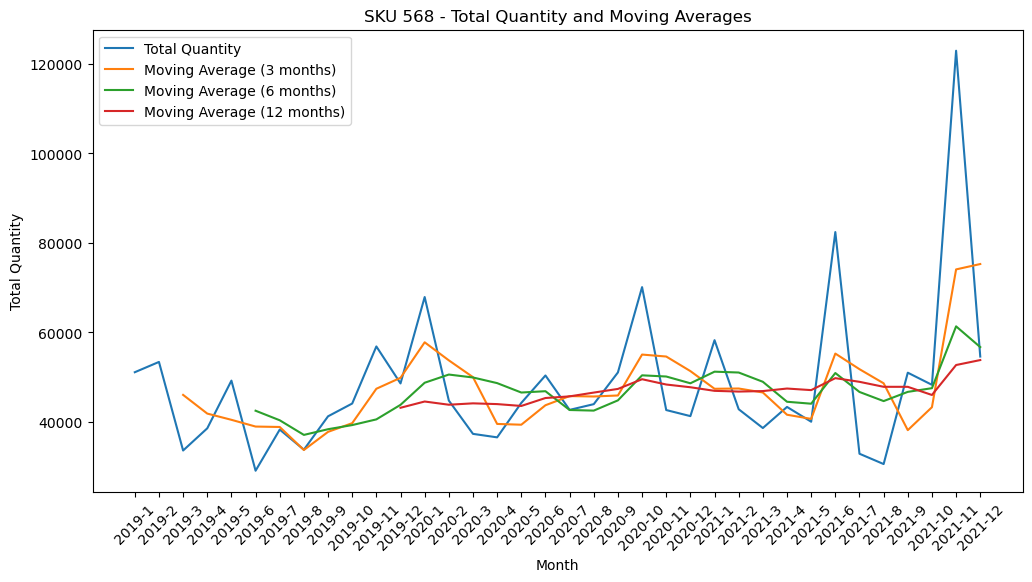

SKU 578


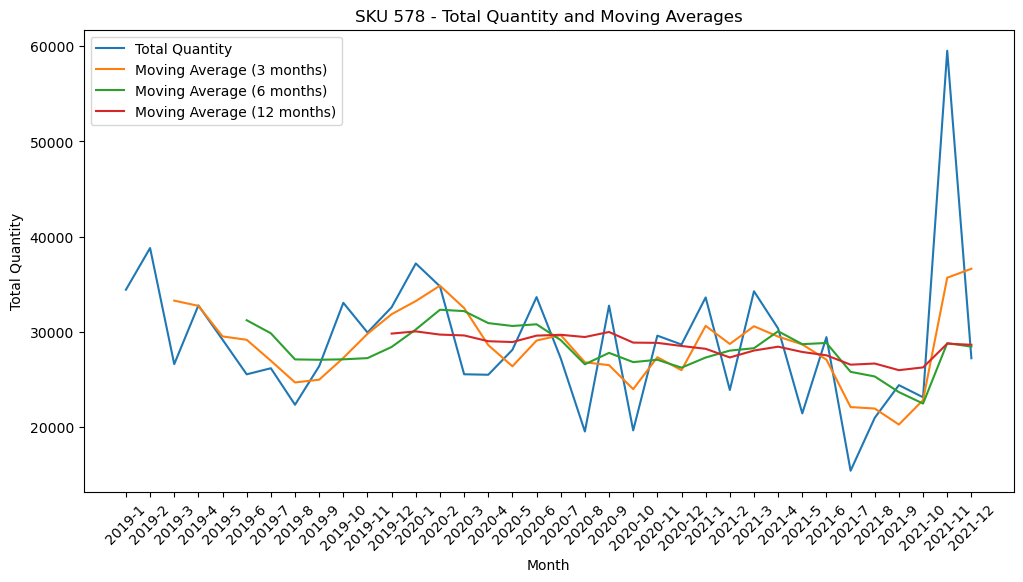

SKU 1050


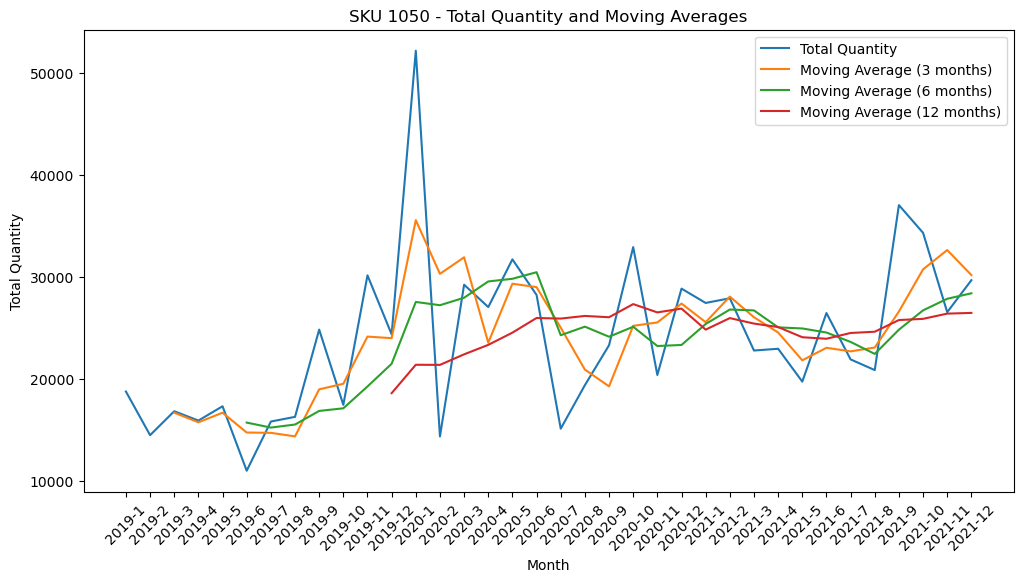

SKU 319


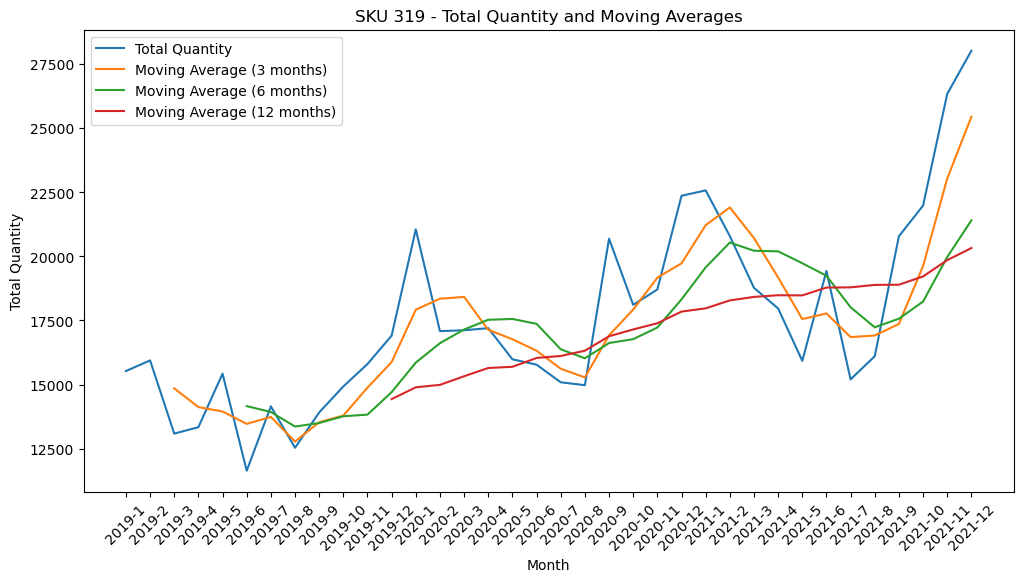

SKU 509


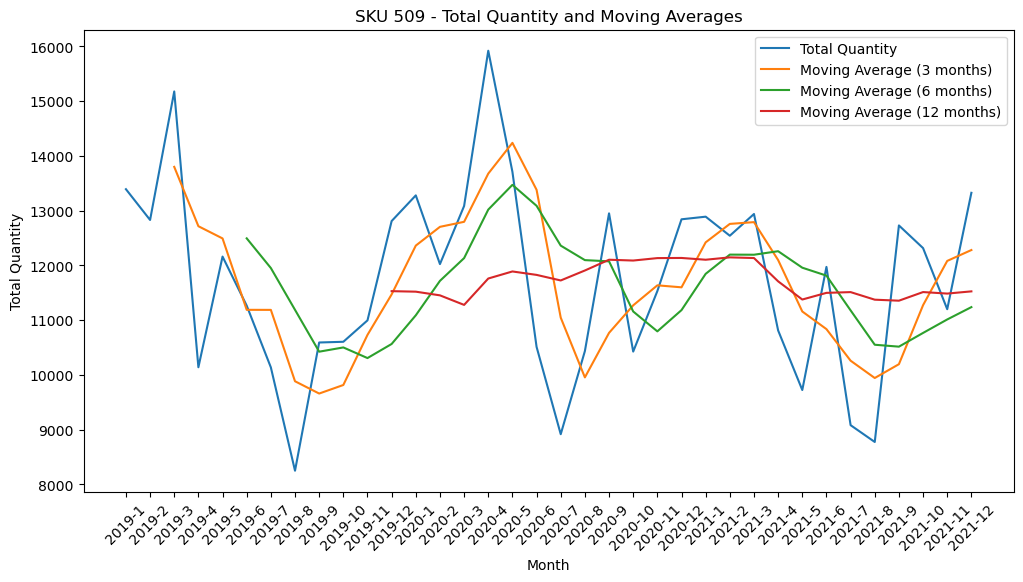

SKU 615


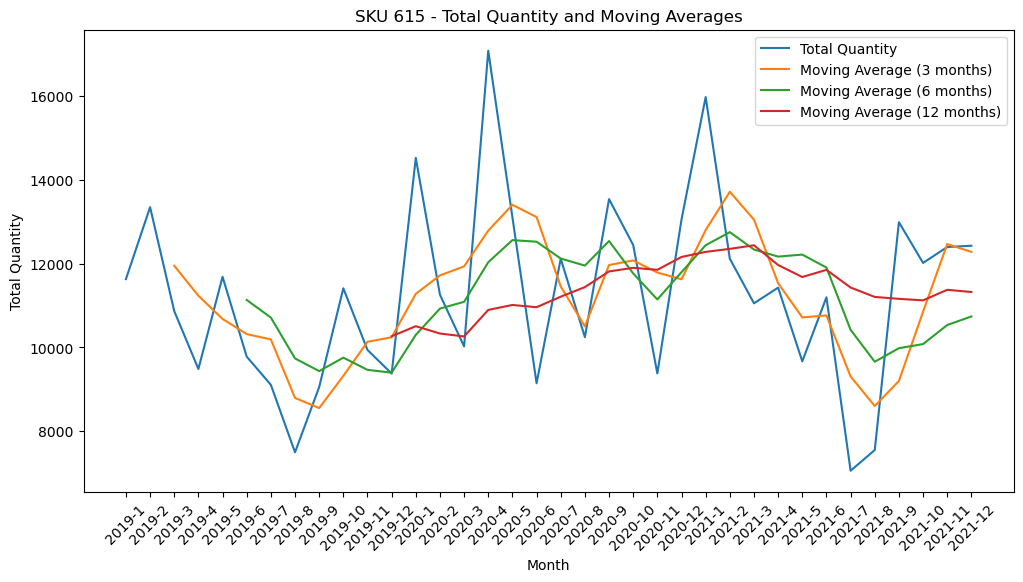

SKU 1018


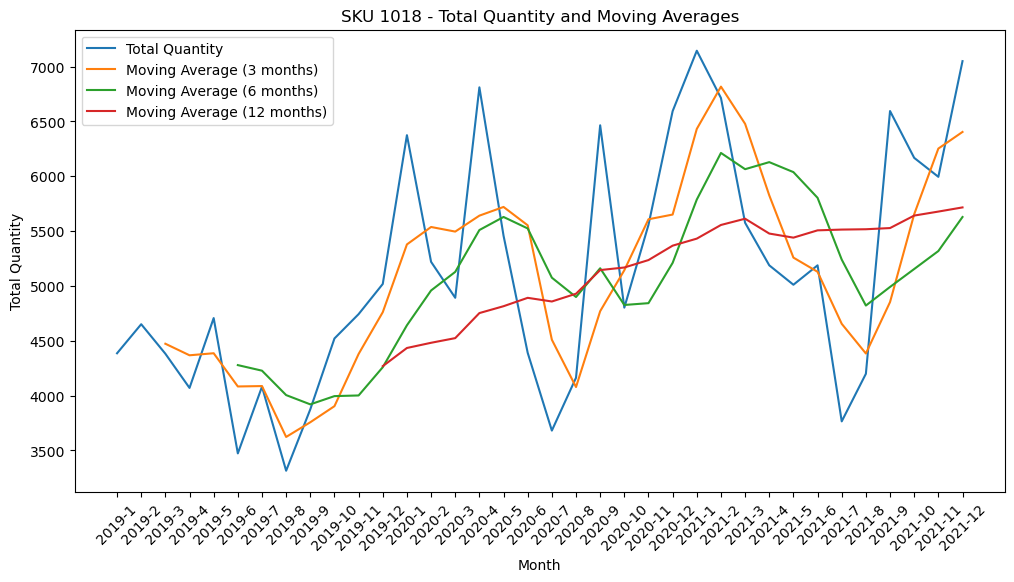

In [17]:
for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    x = sku_data['Year'].astype(str) + '-' + sku_data['Month'].astype(str)
    
    sku_data['Moving_Average_3'] = sku_data['TotalQuantity'].rolling(window=3).mean()
    sku_data['Moving_Average_6'] = sku_data['TotalQuantity'].rolling(window=6).mean()
    sku_data['Moving_Average_12'] = sku_data['TotalQuantity'].rolling(window=12).mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(x, sku_data['TotalQuantity'], label='Total Quantity')
    plt.plot(x, sku_data['Moving_Average_3'], label='Moving Average (3 months)')
    plt.plot(x, sku_data['Moving_Average_6'], label='Moving Average (6 months)')
    plt.plot(x, sku_data['Moving_Average_12'], label='Moving Average (12 months)')
    plt.title(f'SKU {sku_id} - Total Quantity and Moving Averages')
    plt.xlabel('Month')
    plt.ylabel('Total Quantity')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    plt.close()

# Quarterly Sales Analysis

Calculate the total sales of the choosen SKU's for quarterly. It should be 12 rows in total for every SKU.

In [18]:
quarterly_data = df_cleaned.copy()

quarterly_data = quarterly_data.groupby(['Year', 'Quarter', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
quarterly_data

Year  Quarter SkuID  TotalQuantity
0   2019        1  1018          13419
1   2019        1  1050          50137
2   2019        1   319          44549
3   2019        1   509          41402
4   2019        1   568         138149
..   ...      ...   ...            ...
79  2021        4   319          76364
80  2021        4   509          36845
81  2021        4   568         225881
82  2021        4   578         109923
83  2021        4   615          36834

[84 rows x 4 columns]

## Total Quantity Plot for each SKU

SKU 1018


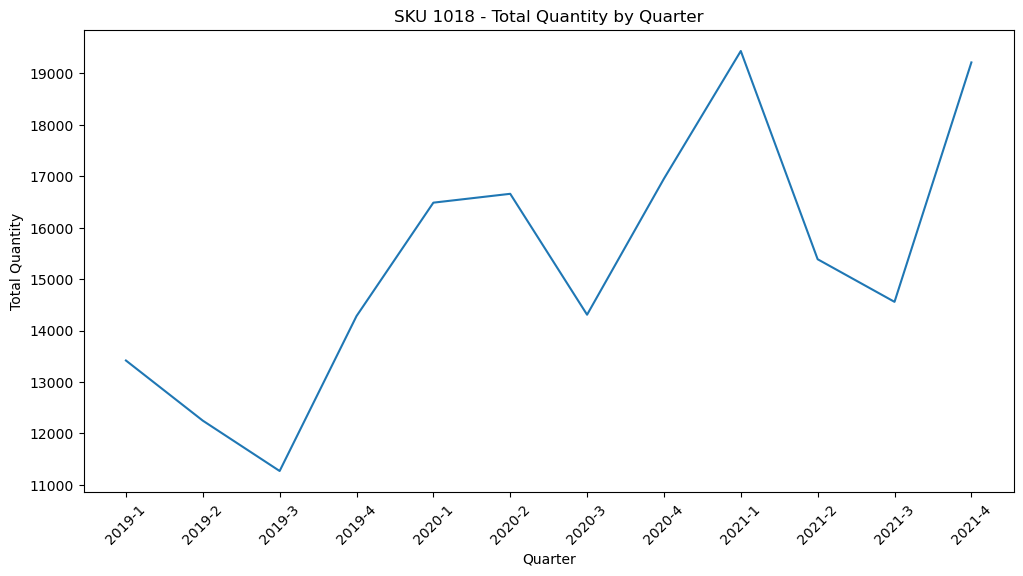

SKU 1050


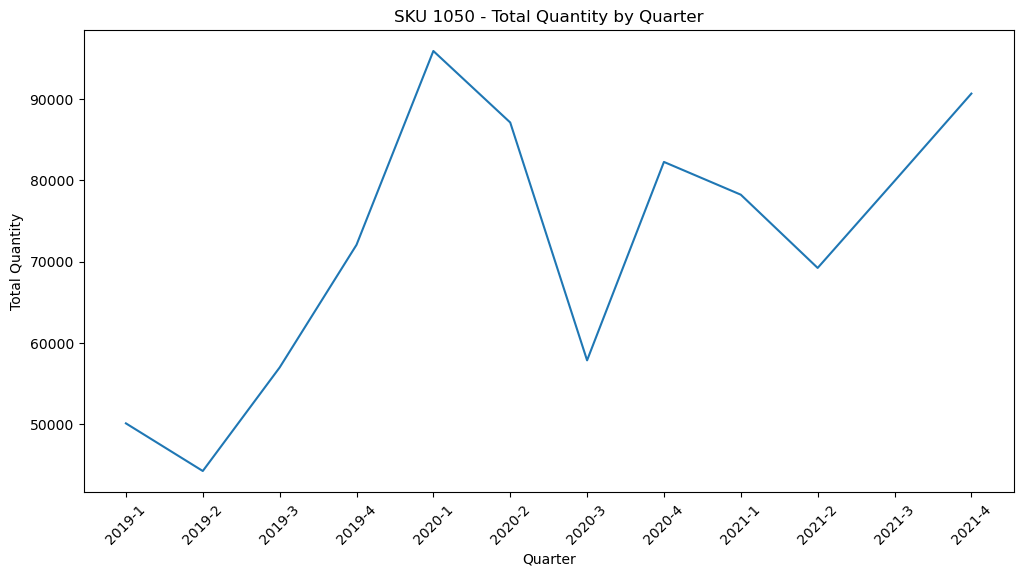

SKU 319


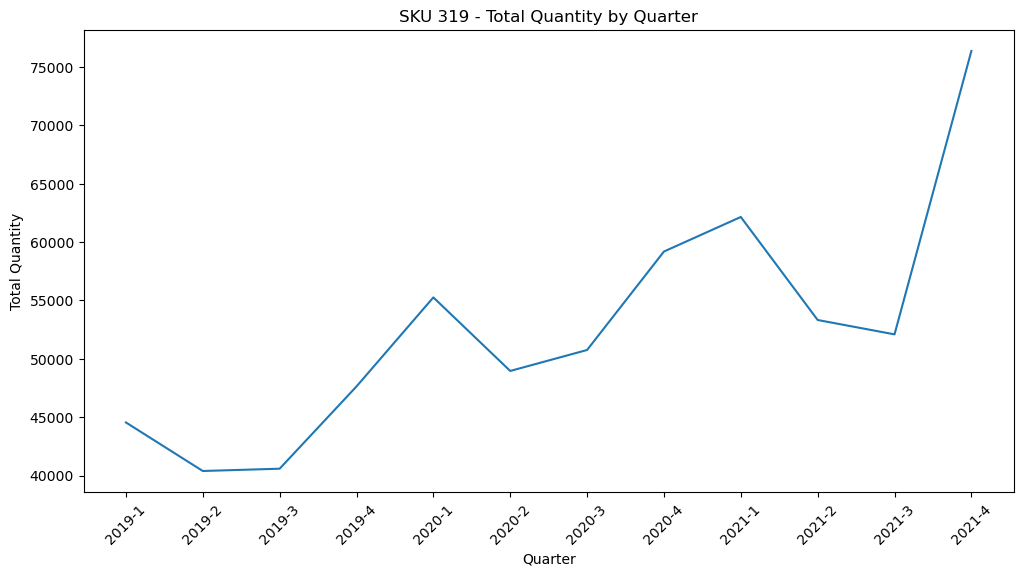

SKU 509


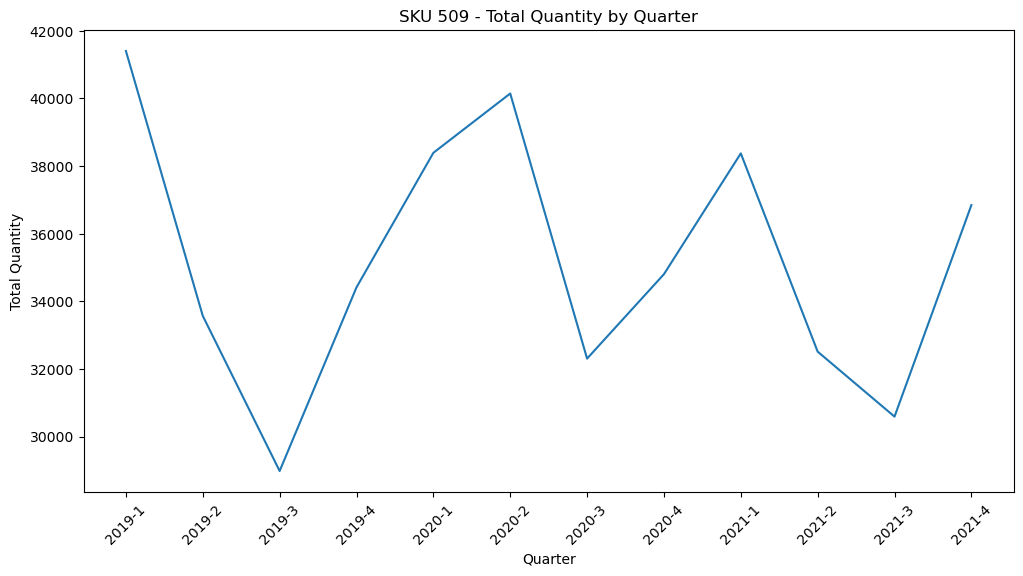

SKU 568


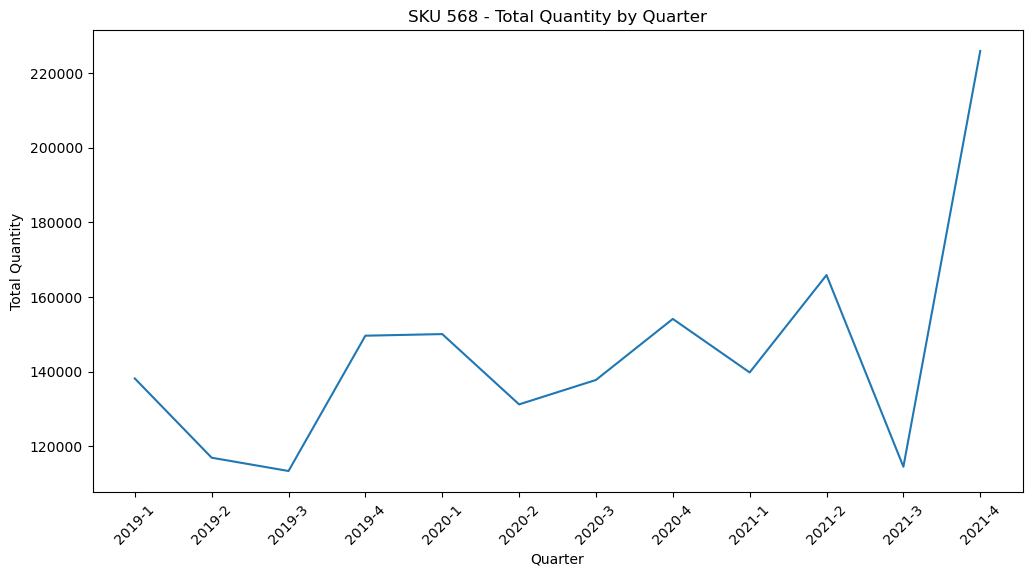

SKU 578


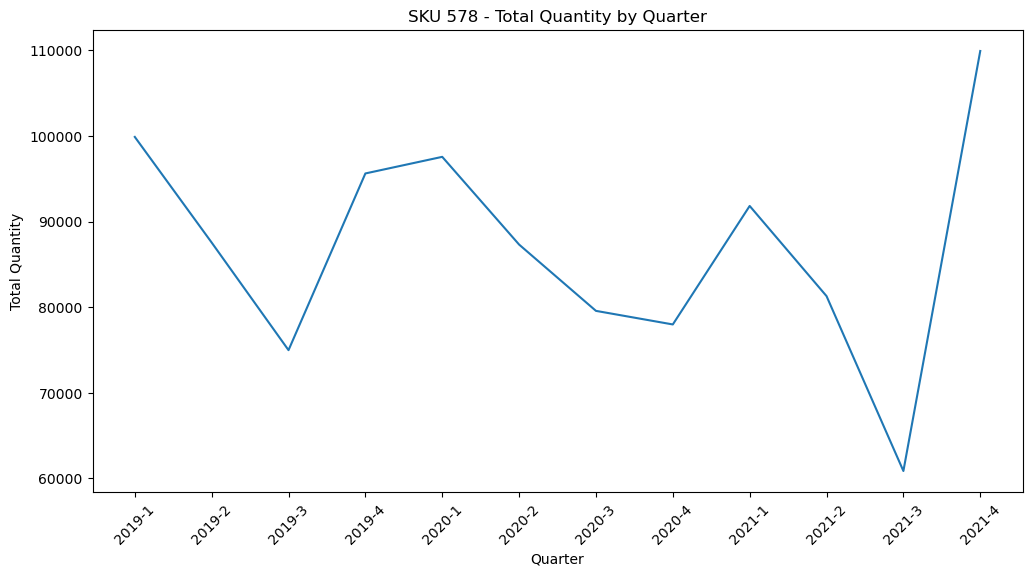

SKU 615


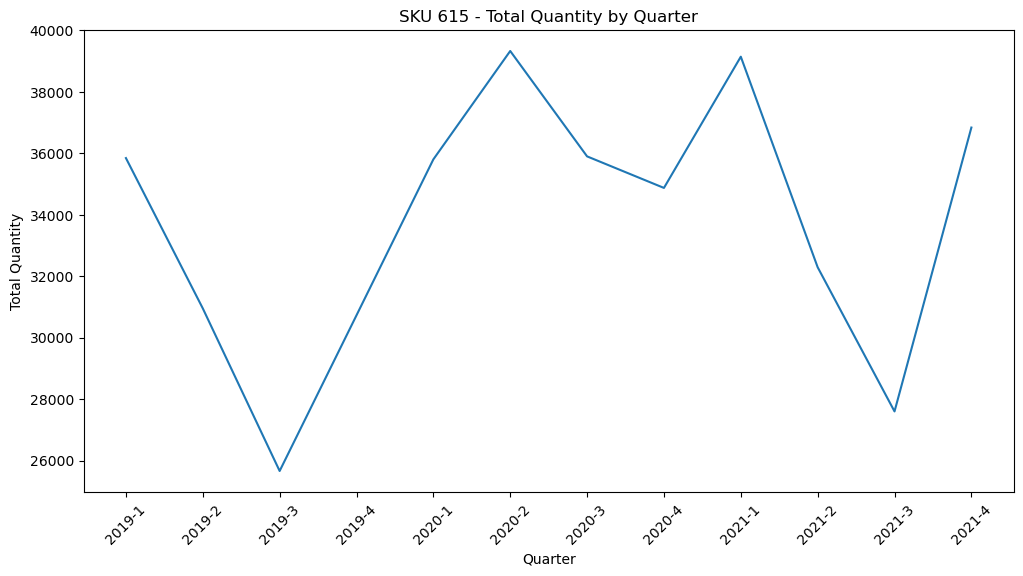

In [19]:
for sku in quarterly_data['SkuID'].unique():
    print(f'SKU {sku}')
    plot_total_quantity(sku, data=quarterly_data)

# R-squared Analysis

Calculate the R-squared value for each SKU to evaluate the model performance.

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def analyze_feature_effects(df, test_size=0.2, random_state=42, additional_cols=None, time_cols=None):
    categorical_cols = []
    
    if time_cols is None:
        time_cols = ['Year', 'Quarter']
        
    if additional_cols is None:
        additional_cols = ['District']
        
    for col in additional_cols:
        if col not in df.columns:
            raise ValueError(f'Column "{col}" not found in the DataFrame.')
        
        # if the column is categorical or object, convert it to category data type
        if df[col].dtype.name in ['category', 'object']:
            df[col] = df[col].astype('category')
            categorical_cols.append(col)

    results = []

    for sku in df['SkuID'].unique():
        df_sku = df[df['SkuID'] == sku].copy()
        df_encoded = pd.get_dummies(df_sku, columns=categorical_cols)
        X = df_encoded.drop(['TotalQuantity', 'SkuID'] + time_cols, axis=1)
        y = df_encoded['TotalQuantity']

        if len(df_encoded) > 1:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            coefficients = dict(zip(X.columns, model.coef_))
            results.append((sku, round(r2, 3), coefficients))
        else:
            results.append((sku, None, None))

    return results

## Assigning the columns

In [21]:
df_cleaned_selected = df_cleaned.copy()
print(df_cleaned_selected.columns)

Index(['SkuID', 'MainDistID', 'District', 'SalesRegionID', 'Date', 'Year',
       'Quarter', 'Month', 'Week', 'TotalQuantity'],
      dtype='object')


In [22]:
# We updated the column arrays when setting up our analysis
time_cols = ['Year', 'Quarter']
additional_cols = ['District']

df_cleaned_selected = df_cleaned_selected.groupby(['SkuID'] +
    time_cols + additional_cols
).agg({'TotalQuantity': 'sum'}).reset_index()

print(df_cleaned_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SkuID          4773 non-null   object
 1   Year           4773 non-null   int64 
 2   Quarter        4773 non-null   int64 
 3   District       4773 non-null   object
 4   TotalQuantity  4773 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 186.6+ KB
None


In [23]:
df_cleaned_selected

SkuID  Year  Quarter      District  TotalQuantity
0     1018  2019        1    ARNAVUTKÖY            164
1     1018  2019        1      ATAŞEHIR              4
2     1018  2019        1      ATAŞEHİR            279
3     1018  2019        1       AVCILAR            699
4     1018  2019        1  BAHÇELIEVLER             41
...    ...   ...      ...           ...            ...
4768   615  2021        4      ÜMRANİYE           2220
4769   615  2021        4       ÜSKÜDAR           1533
4770   615  2021        4         ŞIŞLI             83
4771   615  2021        4          ŞİLE             96
4772   615  2021        4         ŞİŞLİ            309

[4773 rows x 5 columns]

In [24]:
# Run the analysis for each SKU
results = analyze_feature_effects(df_cleaned_selected, additional_cols=additional_cols, time_cols=time_cols)

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results, columns=['SkuID', 'R_squared', 'Coefficients'])
results_df

SkuID  R_squared                                       Coefficients
0  1018      0.850  {'District_ADALAR': 242336151570458.62, 'Distr...
1  1050      0.774  {'District_ADALAR': -542436566056821.06, 'Dist...
2   319      0.817  {'District_ADALAR': 983083017410634.1, 'Distri...
3   509      0.935  {'District_ADALAR': -3404880589142348.5, 'Dist...
4   568      0.847  {'District_ADALAR': -789438807672194.0, 'Distr...
5   578      0.841  {'District_ADALAR': 683304462529037.0, 'Distri...
6   615      0.904  {'District_ADALAR': -185754302944925.6, 'Distr...

### Interpretation for R-squared Analysis

Based on the R-squared analysis, the following columns are used for the analysis in addition to the time columns:

--------

#### 'Year', 'Quarter', 'District', 'MainDistID', 'DistID'
```python
time_cols = ['Year', 'Quarter']
additional_cols = ['District', 'MainDistID', 'DistID']
```

The R-squared values for each SKU are as follows:

| Index | SKU  | R_squared |
|-------|------|-----------|
| 0     | 1018 | 0.047     |
| 1     | 1050 | 0.050     |
| 2     | 319  | 0.053     |
| 3     | 509  | 0.052     |
| 4     | 568  | 0.054     |
| 5     | 578  | 0.045     |
| 6     | 615  | 0.046     |

### Observations
- **Consistent Scores:** Across all SKUs, the evaluation scores range from 0.045 to 0.054, indicating relatively consistent performance across the board.
- **Low Variability:** The evaluation scores do not exhibit significant variability, suggesting that the model performs similarly for different SKUs.

========


#### 'Year', 'Month', 'District', 'MainDistID'
```python
time_cols = ['Year', 'Month']
additional_cols = ['District', 'MainDistID']
```

| Index | SKU ID | Evaluation Score |
| --- | --- | --- |
| 0 | 1018 | 0.634 |
| 1 | 1050 | 0.622 |
| 2 | 319 | 0.844 |
| 3 | 509 | 0.780 |
| 4 | 568 | 0.677 |
| 5 | 578 | 0.556 |
| 6 | 615 | 0.659 |

### Interpretation
-   **High Evaluation Score**: SKU 319 has the highest evaluation score (0.844), indicating strong performance.
-   **Moderate Evaluation Scores**: SKUs 509, 568, 1018, and 615 have moderate evaluation scores ranging from 0.634 to 0.780.
-   **Lower Evaluation Scores**: SKUs 1050 and 578 have the lowest evaluation scores, with scores of 0.622 and 0.


#### 'Year', 'Quarter', 'District', 'MainDistID'
```python
time_cols = ['Year', 'Quarter']
additional_cols = ['District', 'MainDistID']
```

The R-squared values for each SKU are as follows:

| Index | SKU | R_squared |
| --- | --- | --- |
| 0 | 1018 | 0.816 |
| 1 | 1050 | 0.767 |
| 2 | 319 | 0.874 |
| 3 | 509 | 0.863 |
| 4 | 568 | 0.817 |
| 5 | 578 | 0.686 |
| 6 | 615 | 0.793 |

### Observations
- **Improved Scores:** The evaluation scores have significantly improved, ranging from 0.686 to 0.874, indicating better performance.
- **High Variability:** The evaluation scores exhibit more variability compared to the previous analysis, suggesting that the model's performance varies across different SKUs.
- **Top Performers:** SKUs 319 and 509 have the highest evaluation scores, indicating that the model performs exceptionally well for these SKUs.
- **SKU 578:** SKU 578 has the lowest evaluation score, suggesting that the model may not perform as effectively for this SKU.
- **Overall Performance:** The model performs well across most SKUs, with the majority of evaluation scores above 0.75, indicating a good fit to the data.

#### 'Year', 'Quarter', 'District', 'SalesRegionID'
```python
time_cols = ['Year', 'Quarter']
additional_cols = ['District', 'SalesRegionID']
```
1018,0.006
1050,0.009
319,0.011
509,0.010
568,0.010
578,0.006
615,0.008


In [25]:
import numpy as np

# Convert coefficients to a DataFrame for easier analysis
coefficients_df = pd.DataFrame()
coefficients_df['SkuID'] = results_df['SkuID']

for i, row in results_df.iterrows():
    coefficients = row['Coefficients']
    if coefficients is not None:
        for col, coef in coefficients.items():
            col_name = f'{col}'
            if col_name not in coefficients_df:
                coefficients_df[col_name] = np.nan
            coefficients_df.loc[i, col_name] = coef
        
coefficients_df    

SkuID  District_ADALAR  District_ARNAVUTKÖY  District_ATAŞEHIR  \
0  1018     2.423362e+14         2.423362e+14       2.423362e+14   
1  1050    -5.424366e+14        -5.424366e+14      -5.424366e+14   
2   319     9.830830e+14         9.830830e+14       9.830830e+14   
3   509    -3.404881e+15        -3.404881e+15      -3.404881e+15   
4   568    -7.894388e+14        -7.894388e+14      -7.894388e+14   
5   578     6.833045e+14         6.833045e+14       6.833045e+14   
6   615    -1.857543e+14        -1.857543e+14      -1.857543e+14   

   District_ATAŞEHİR  District_AVCILAR  District_BAHÇELIEVLER  \
0       2.423362e+14      2.423362e+14           2.423362e+14   
1      -5.424366e+14     -5.424366e+14          -5.424366e+14   
2       9.830830e+14      9.830830e+14           9.830830e+14   
3      -3.404881e+15     -3.404881e+15          -3.404881e+15   
4      -7.894388e+14     -7.894388e+14          -7.894388e+14   
5       6.833045e+14      6.833045e+14           6.833045e+14   
6      -1.857543e+14     -1.857543e+14          -1.857543e+14   

   District_BAHÇELİEVLER  District_BAKIRKÖY  District_BAYRAMPAŞA  ...  \
0           2.423362e+14       2.423362e+14         2.423362e+14  ...   
1          -5.424366e+14      -5.424366e+14        -5.424366e+14  ...   
2           9.830830e+14       9.830830e+14         9.830830e+14  ...   
3          -3.404881e+15      -3.404881e+15        -3.404881e+15  ...   
4          -7.894388e+14      -7.894388e+14        -7.894388e+14  ...   
5           6.833045e+14       6.833045e+14         6.833045e+14  ...   
6          -1.857543e+14      -1.857543e+14        -1.857543e+14  ...   

   District_nan  District_ÇATALCA  District_ÇEKMEKÖY  District_ÜMRANIYE  \
0  2.423362e+14      2.423362e+14       2.423362e+14       2.423362e+14   
1 -5.424366e+14     -5.424366e+14      -5.424366e+14      -5.424366e+14   
2  9.830830e+14      9.830830e+14       9.830830e+14       9.830830e+14   
3 -3.404881e+15     -3.404881e+15      -3.404881e+15      -3.404881e+15   
4 -7.894388e+14     -7.894388e+14      -7.894388e+14      -7.894388e+14   
5  6.833045e+14      6.833045e+14       6.833045e+14       6.833045e+14   
6 -1.857543e+14     -1.857543e+14      -1.857543e+14      -1.857543e+14   

   District_ÜMRANİYE  District_ÜSKÜDAR  District_ŞILE  District_ŞIŞLI  \
0       2.423362e+14      2.423362e+14   2.423362e+14    2.423362e+14   
1      -5.424366e+14     -5.424366e+14  -5.424366e+14   -5.424366e+14   
2       9.830830e+14      9.830830e+14   9.830830e+14    9.830830e+14   
3      -3.404881e+15     -3.404881e+15  -3.404881e+15   -3.404881e+15   
4      -7.894388e+14     -7.894388e+14  -7.894388e+14   -7.894388e+14   
5       6.833045e+14      6.833045e+14   6.833045e+14    6.833045e+14   
6      -1.857543e+14     -1.857543e+14  -1.857543e+14   -1.857543e+14   

   District_ŞİLE  District_ŞİŞLİ  
0   2.423362e+14    2.423362e+14  
1  -5.424366e+14   -5.424366e+14  
2   9.830830e+14    9.830830e+14  
3  -3.404881e+15   -3.404881e+15  
4  -7.894388e+14   -7.894388e+14  
5   6.833045e+14    6.833045e+14  
6  -1.857543e+14   -1.857543e+14  

[7 rows x 61 columns]

<Figure size 1600x1000 with 0 Axes>

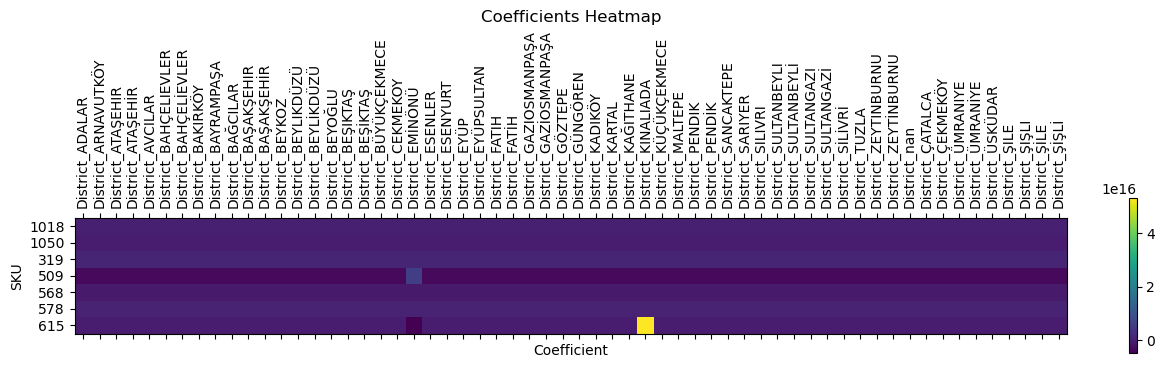

In [26]:
# heatmap for coefficients
plt.figure(figsize=(16, 10))
plt.matshow(coefficients_df.drop('SkuID', axis=1), cmap='viridis')
plt.colorbar()
plt.xticks(range(len(coefficients_df.columns) - 1), coefficients_df.columns[1:], rotation=90)
plt.yticks(range(len(coefficients_df)), coefficients_df['SkuID'])
plt.xlabel('Coefficient')
plt.ylabel('SKU')
plt.title('Coefficients Heatmap')
plt.show()

In [27]:
avg_maindistid_coefficients = coefficients_df.filter(regex='MainDistID').mean()

avg_maindistid_coefficients_df = pd.DataFrame(avg_maindistid_coefficients, columns=['Average Coefficient'])

print('Average Coefficients for MainDistID:')
avg_maindistid_coefficients_df

Average Coefficients for MainDistID:


Empty DataFrame
Columns: [Average Coefficient]
Index: []

In [28]:
avg_district_coefficients = coefficients_df.filter(regex='District').mean()

avg_district_coefficients_df = pd.DataFrame(avg_district_coefficients, columns=['Average Coefficient'])

print('Average Coefficients for District:')
avg_district_coefficients_df

Average Coefficients for District:


Average Coefficient
District_ADALAR               -4.305409e+14
District_ARNAVUTKÖY           -4.305409e+14
District_ATAŞEHIR             -4.305409e+14
District_ATAŞEHİR             -4.305409e+14
District_AVCILAR              -4.305409e+14
District_BAHÇELIEVLER         -4.305409e+14
District_BAHÇELİEVLER         -4.305409e+14
District_BAKIRKÖY             -4.305409e+14
District_BAYRAMPAŞA           -4.305409e+14
District_BAĞCILAR             -4.305409e+14
District_BAŞAKŞEHIR           -4.305409e+14
District_BAŞAKŞEHİR           -4.305409e+14
District_BEYKOZ               -4.305409e+14
District_BEYLIKDÜZÜ           -4.305409e+14
District_BEYLİKDÜZÜ           -4.305409e+14
District_BEYOĞLU              -4.305409e+14
District_BEŞIKTAŞ             -4.305409e+14
District_BEŞİKTAŞ             -4.305409e+14
District_BÜYÜKÇEKMECE         -4.305409e+14
District_CEKMEKOY             -4.305409e+14
District_EMİNÖNÜ               2.110761e+14
District_ESENLER              -4.305409e+14
District_ESENYURT             -4.305409e+14
District_EYÜP                 -4.305409e+14
District_EYÜPSULTAN           -4.305409e+14
District_FATIH                -4.305409e+14
District_FATİH                -4.305409e+14
District_GAZIOSMANPAŞA        -4.305409e+14
District_GAZİOSMANPAŞA        -4.305409e+14
District_GÖZTEPE              -4.305409e+14
District_GÜNGÖREN             -4.305409e+14
District_KADIKÖY              -4.305409e+14
District_KARTAL               -4.305409e+14
District_KAĞITHANE            -4.305409e+14
District_KINALIADA             7.199753e+15
District_KÜÇÜKÇEKMECE         -4.305409e+14
District_MALTEPE              -4.305409e+14
District_PENDIK               -4.305409e+14
District_PENDİK               -4.305409e+14
District_SANCAKTEPE           -4.305409e+14
District_SARIYER              -4.305409e+14
District_SILIVRI              -4.305409e+14
District_SULTANBEYLI          -4.305409e+14
District_SULTANBEYLİ          -4.305409e+14
District_SULTANGAZI           -4.305409e+14
District_SULTANGAZİ           -4.305409e+14
District_SİLİVRİ              -4.305409e+14
District_TUZLA                -4.305409e+14
District_ZEYTINBURNU          -4.305409e+14
District_ZEYTİNBURNU          -4.305409e+14
District_nan                  -4.305409e+14
District_ÇATALCA              -4.305409e+14
District_ÇEKMEKÖY             -4.305409e+14
District_ÜMRANIYE             -4.305409e+14
District_ÜMRANİYE             -4.305409e+14
District_ÜSKÜDAR              -4.305409e+14
District_ŞILE                 -4.305409e+14
District_ŞIŞLI                -4.305409e+14
District_ŞİLE                 -4.305409e+14
District_ŞİŞLİ                -4.305409e+14

In [29]:
avg_distid_coefficients = coefficients_df.filter(regex='DistID').mean()

avg_distid_coefficients_df = pd.DataFrame(avg_distid_coefficients, columns=['Average Coefficient'])

print('Average Coefficients for DistID:')
avg_distid_coefficients_df

Average Coefficients for DistID:


Empty DataFrame
Columns: [Average Coefficient]
Index: []

# Forecasting

In [30]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863002 entries, 0 to 863001
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   SkuID          863002 non-null  object  
 1   MainDistID     863002 non-null  object  
 2   District       863002 non-null  object  
 3   SalesRegionID  863002 non-null  category
 4   Date           863002 non-null  object  
 5   Year           863002 non-null  int64   
 6   Quarter        863002 non-null  int64   
 7   Month          863002 non-null  int64   
 8   Week           863002 non-null  int64   
 9   TotalQuantity  863002 non-null  int64   
dtypes: category(1), int64(5), object(4)
memory usage: 60.1+ MB


In [31]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

def forecast_total_quantity_seasonal(df, time_range, district, skuid, param_grid=None):
    grupBY = ['SkuID', 'Year']
    
    if param_grid is None:
        param_grid = { 
            'Exponential Smoothing': {'seasonal': ['add', 'mul']},
            'ARIMA': {'order': [(1, 1, 1), (1, 0, 1), (1, 1, 2)]},
            'SARIMA': {
                'order': [(1, 1, 1), (1, 0, 1), (1, 1, 2)], 
                'seasonal_order': [(1, 1, 1, 4), (1, 1, 1, 12), (1, 1, 1, 52)]
            }
        }
    
    if skuid is None:
        raise ValueError("SKU ID cannot be None.")
    
    if district is None:
        df_filtered = df[df['SkuID'] == skuid]
    else:
        df_filtered = df[(df['District'] == district) & (df['SkuID'] == skuid)]
        grupBY.append('District')
    
    # Aggregate data based on the time range
    if time_range == 'Quarter':
        df_agg = df_filtered.groupby(grupBY + ["Quarter"]).agg({'TotalQuantity': 'sum'}).reset_index()
        df_agg['Date'] = pd.to_datetime(df_agg['Year'].astype(str) + 'Q' + df_agg['Quarter'].astype(str))
        df_agg.set_index('Date', inplace=True)
        df_agg.index.freq = pd.infer_freq(df_agg.index)
        seasonal_periods = 4
        window_size = 2
        
    elif time_range == 'Month':
        df_agg = df_filtered.groupby(grupBY + ['Month']).agg({'TotalQuantity': 'sum'}).reset_index()
        df_agg['Date'] = pd.to_datetime(df_agg['Year'].astype(str) + df_agg['Month'].astype(str).str.zfill(2), format='%Y%m')
        df_agg.set_index('Date', inplace=True)
        df_agg.index.freq = pd.infer_freq(df_agg.index)
        seasonal_periods = 12
        window_size = 2
        
    elif time_range == 'Week':
        df_agg = df_filtered.groupby(grupBY + ['Week']).agg({'TotalQuantity': 'sum'}).reset_index()
        df_agg['Date'] = pd.to_datetime(df_agg['Year'].astype(str) + df_agg['Week'].astype(str).str.zfill(2) + '0', format='%Y%W%w')
        df_agg.set_index('Date', inplace=True)
        df_agg.index.freq = pd.infer_freq(df_agg.index)
        seasonal_periods = 52
        window_size = 2
        
    else:
        raise ValueError("Invalid time range. Choose from 'Quarter', 'Month', or 'Week'.")
    
    # Split the data into train and test sets
    train = df_agg.iloc[:-seasonal_periods]
    test = df_agg.iloc[-seasonal_periods:]
    
    # Define the models
    seasonal_models = {
        'Triple Exponential Smoothing': ExponentialSmoothing(train['TotalQuantity'], seasonal=param_grid['Exponential Smoothing']['seasonal'][0], seasonal_periods=seasonal_periods), 
        'ARIMA': ARIMA(train['TotalQuantity'], order=param_grid['ARIMA']['order'][0]),
        'SARIMA': SARIMAX(train['TotalQuantity'], order=param_grid['SARIMA']['order'][0], seasonal_order=param_grid['SARIMA']['seasonal_order'][0], seasonal_periods=seasonal_periods)
    }
    
    base_models = {
        'Exponential Smoothing': ExponentialSmoothing(train['TotalQuantity'], seasonal=None, seasonal_periods=None),
        'Naive': train['TotalQuantity'].shift(1),
        'Moving Average': train['TotalQuantity'].rolling(window=window_size).mean()
    }
    
    
    
    forecasts = {}
    metrics = {}
    
    # Fit and forecast with seasonal models
    for name, model in seasonal_models.items():
        model_fit = model.fit()
        forecast = model_fit.forecast(seasonal_periods)
        forecasts[name] = forecast
        
        metrics[name] = {
            'MAPE': mean_absolute_percentage_error(test['TotalQuantity'], forecast),
            'MSE': mean_squared_error(test['TotalQuantity'], forecast),
            'RMSE': np.sqrt(mean_squared_error(test['TotalQuantity'], forecast)),
            'MAD': mean_absolute_error(test['TotalQuantity'], forecast)
        }
        
    # Fit and forecast with base models
    for name, model in base_models.items():
        if name == 'Naive':
            forecast = model.iloc[-seasonal_periods:]
        elif name == 'Moving Average':
            forecast = model.iloc[-seasonal_periods:]
        else:
            model_fit = model.fit()
            forecast = model_fit.forecast(seasonal_periods)
        
        forecasts[name] = forecast
        
        metrics[name] = {
            'MAPE': mean_absolute_percentage_error(test['TotalQuantity'], forecast),
            'MSE': mean_squared_error(test['TotalQuantity'], forecast),
            'RMSE': np.sqrt(mean_squared_error(test['TotalQuantity'], forecast)),
            'MAD': mean_absolute_error(test['TotalQuantity'], forecast)
        }
            
    
    plot_forecasts(forecasts, test, title='Total Quantity Forecast', xlabel='Date', ylabel='Total Quantity')
    
    return forecasts, metrics

In [32]:
def plot_forecasts(forecasts, test, title='Total Quantity Forecast', xlabel='Date', ylabel='Total Quantity'):
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test['TotalQuantity'], label='Actual')
    
    for name, forecast in forecasts.items():
        plt.plot(test.index, forecast, label=name)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    
def plot_metrics(metrics, title='Forecast Metrics', ylabel='Value'):
    metrics_df = pd.DataFrame(metrics).T
    metrics_df.plot(kind='bar', figsize=(12, 6))
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)
    plt.show()
    
    

# Results for Forecasting

### Iterating over each SKU and Time Range

This function iterates over a list of SKU IDs, performs forecasting for each SKU over specified time ranges, collects the forecast performance metrics, and stores them in a DataFrame. Here's a detailed breakdown of the function:

1.  **Initialization**:

    -   `metrics_df_by_sku` is initialized as an empty list. This will later hold dictionaries with performance metrics for each SKU.
2.  **Iterating Over SKUs**:

    -   The function assumes `all_sku_ids` is a predefined list of SKU IDs.
    -   It iterates over each SKU in `all_sku_ids`.
3.  **Logging**:

    -   For each SKU, a message is printed indicating the start of forecasting for that SKU.
4.  **Iterating Over Time Ranges**:
    -   Inside the SKU loop, it iterates over a list of time ranges (in this case, just `['Quarter']` but you can add also `['Month', 'Week']`).
    -   For each time range, a message is printed indicating the start of forecasting for that time range.
5.  **Forecasting and Metric Collection**:

    -   The `forecast_total_quantity_seasonal` function is called with the cleaned data frame (`df_cleaned`), the current time range, `None` for a placeholder parameter (possibly indicating no specific district), and the current SKU.
    -   This function returns forecasts and metrics. The exact structure of `metrics` isn't specified, but it is assumed to be a dictionary where each key is a model name and each value is another dictionary containing the performance metrics (`MAPE`, `MSE`, `RMSE`, `MAD`).
6.  **Appending Metrics**:

    -   For each model in the `metrics` dictionary, the function constructs a dictionary with the following key-value pairs:
        -   `SKU`: The current SKU.
        -   `District`: Set to `'All'` (indicating metrics for all districts).
        -   `Time Range`: The current time range.
        -   `Model`: The model name.
        -   `MAPE`, `MSE`, `RMSE`, `MAD`: The respective performance metrics for the model.
    -   This dictionary is appended to the `metrics_df_by_sku` list.
7.  **Converting to DataFrame**:

    -   After processing all SKUs and time ranges, `metrics_df_by_sku` (a list of dictionaries) is converted into a Pandas DataFrame.

Forecasting for SKU 568
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09425D+00    |proj g|=  8.25178D-01

At iterate    5    f=  3.87935D+00    |proj g|=  4.90415D-02

At iterate   10    f=  3.84623D+00    |proj g|=  8.24304D-02

At iterate   15    f=  3.84156D+00    |proj g|=  1.39782D-02

At iterate   20    f=  3.84115D+00    |proj g|=  6.05089D-03

At iterate   25    f=  3.84102D+00    |proj g|=  8.85640D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


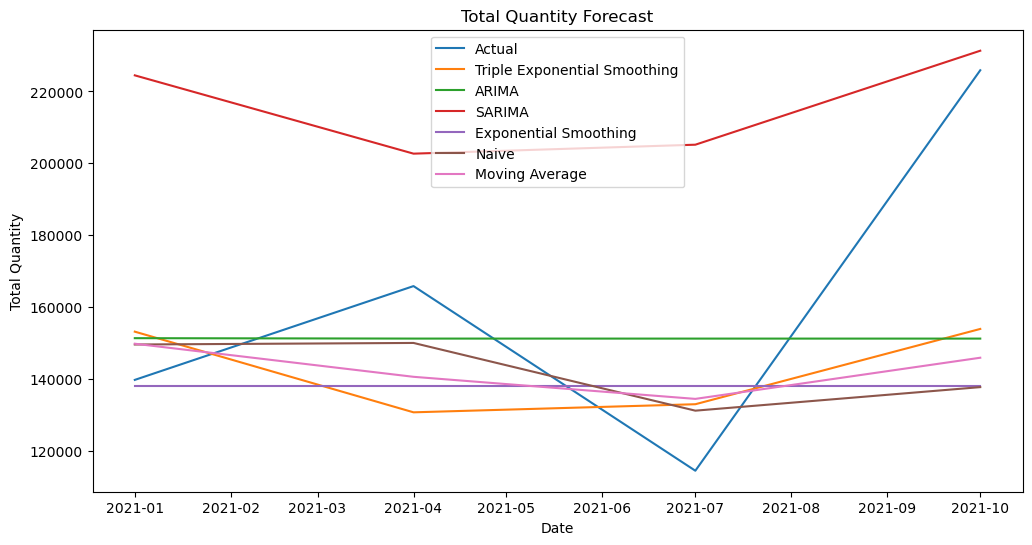

Forecasting for SKU 578
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11178D+00    |proj g|=  6.09134D-01

At iterate    5    f=  3.85577D+00    |proj g|=  5.82489D-02


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
 This problem is unconstrained.



At iterate   10    f=  3.82060D+00    |proj g|=  1.28369D-02

At iterate   15    f=  3.81974D+00    |proj g|=  1.02610D-03

At iterate   20    f=  3.81968D+00    |proj g|=  1.58871D-04

At iterate   25    f=  3.81968D+00    |proj g|=  3.10760D-04

At iterate   30    f=  3.81959D+00    |proj g|=  6.13365D-03

At iterate   35    f=  3.81321D+00    |proj g|=  7.27126D-02

At iterate   40    f=  3.59160D+00    |proj g|=  1.20800D+00

At iterate   45    f=  3.31446D+00    |proj g|=  3.02295D-01

At iterate   50    f=  3.20949D+00    |proj g|=  1.34044D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


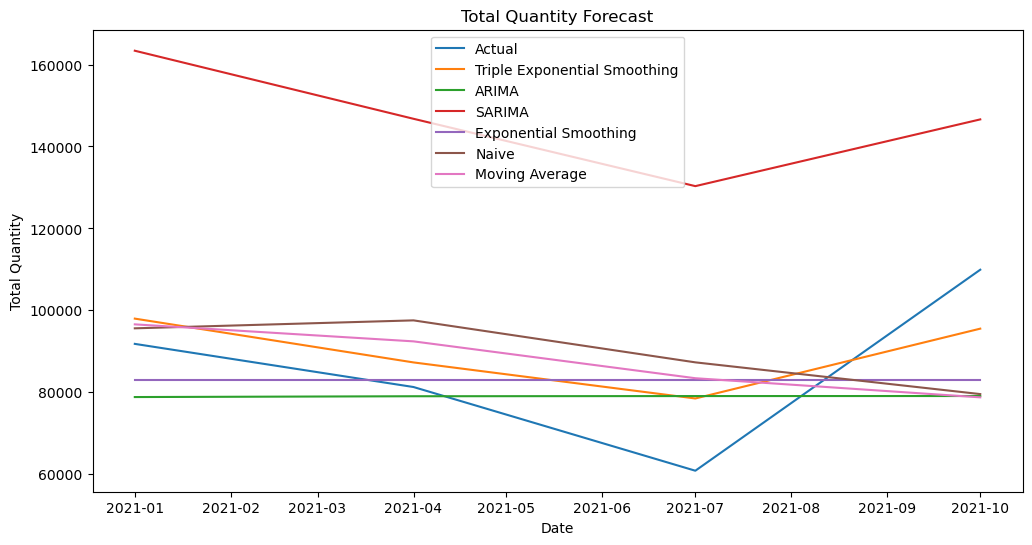

Forecasting for SKU 1050
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36106D+00    |proj g|=  1.30821D-01

At iterate    5    f=  4.20654D+00    |proj g|=  3.54134D-02

At iterate   10    f=  4.18986D+00    |proj g|=  7.40569D-03

At iterate   15    f=  4.18705D+00    |proj g|=  7.25956D-03

At iterate   20    f=  4.18500D+00    |proj g|=  1.23667D-03

At iterate   25    f=  4.18470D+00    |proj g|=  2.76923D-04

At iterate   30    f=  4.18466D+00    |proj g|=  4.37834D-04

At iterate   35    f=  4.18464D+00    |proj g|=  4.94253D-04

At iterate   40    f=  4.18463D+00    |proj g|=  7.70411D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = num

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


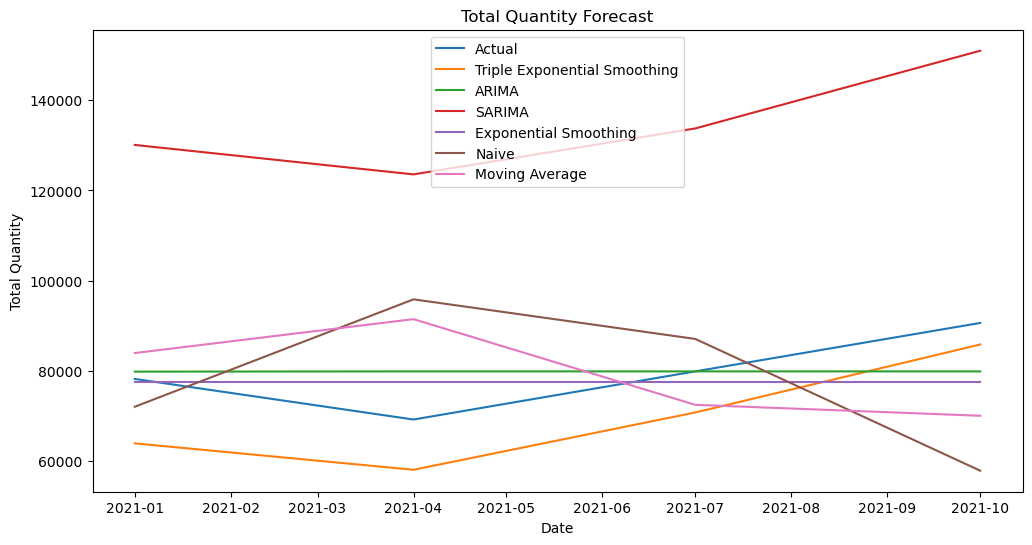

Forecasting for SKU 319
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34020D+00    |proj g|=  2.30549D+00

At iterate    5    f=  3.15159D+00    |proj g|=  2.35453D-01

At iterate   10    f=  3.13538D+00    |proj g|=  6.27569D-01

At iterate   15    f=  3.10511D+00    |proj g|=  4.63863D-02

At iterate   20    f=  3.10228D+00    |proj g|=  2.62164D-02

At iterate   25    f=  3.10088D+00    |proj g|=  8.97716D-03

At iterate   30    f=  3.10045D+00    |proj g|=  1.57906D-03

At iterate   35    f=  3.10035D+00    |proj g|=  1.07975D-03

At iterate   40    f=  3.10035D+00    |proj g|=  8.80299D-04

At iterate   45    f=  3.10018D+00    |proj g|=  1.54046D-02

At iterate   50    f=  3.09317D+00    |proj g|=  8.06036D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function eval

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


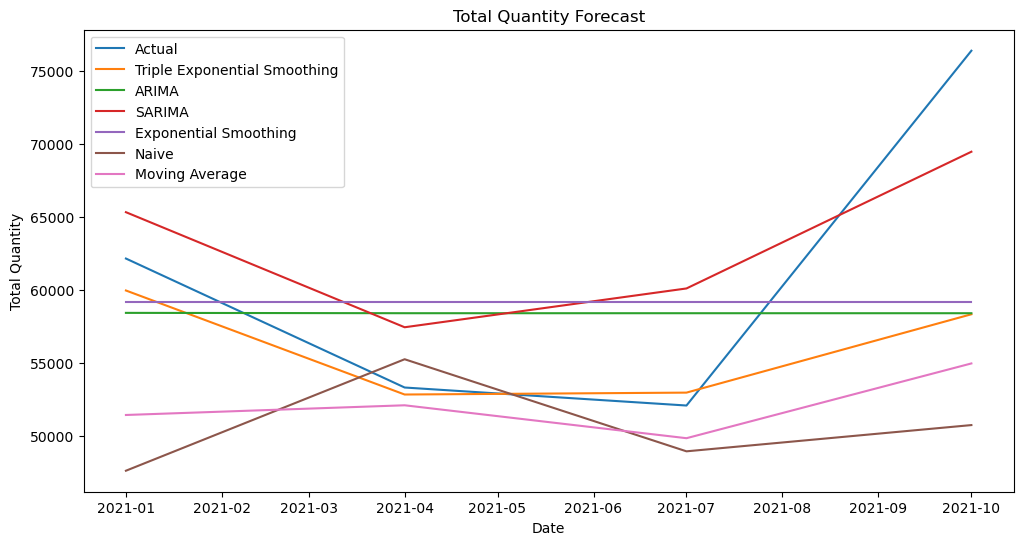

Forecasting for SKU 509
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81066D+00    |proj g|=  1.65338D+00

At iterate    5    f=  3.58622D+00    |proj g|=  1.19005D-01

At iterate   10    f=  3.57944D+00    |proj g|=  2.01546D-02

At iterate   15    f=  3.57340D+00    |proj g|=  1.64107D-02

At iterate   20    f=  3.57287D+00    |proj g|=  1.02077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     25      1     0     0   6.

 This problem is unconstrained.


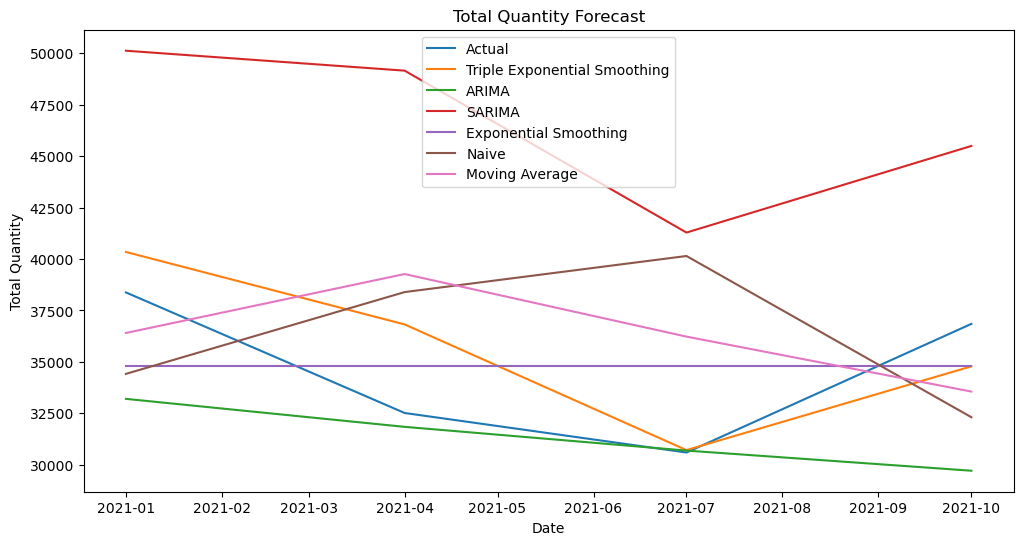

Forecasting for SKU 615
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81246D+00    |proj g|=  1.11436D+00

At iterate    5    f=  3.59359D+00    |proj g|=  4.87641D-02

At iterate   10    f=  3.56561D+00    |proj g|=  4.50849D-03

At iterate   15    f=  3.56549D+00    |proj g|=  1.43957D-04

At iterate   20    f=  3.56548D+00    |proj g|=  5.38060D-04

At iterate   25    f=  3.56542D+00    |proj g|=  6.45825D-03

At iterate   30    f=  3.56021D+00    |proj g|=  1.29848D-01

At iterate   35    f=  3.44593D+00    |proj g|=  4.23208D-01

At iterate   40    f=  3.24117D+00    |proj g|=  5.69060D-01

At iterate   45    f=  3.06677D+00    |proj g|=  3.37156D-01

At iterate   50    f=  3.00500D+00    |proj g|=  7.83847D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function eval

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


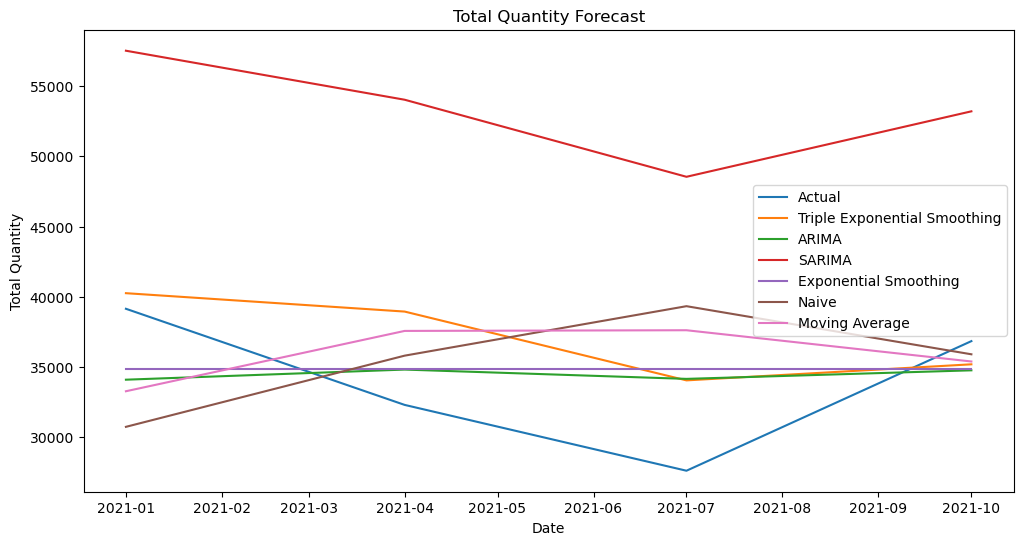

Forecasting for SKU 1018
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17691D+00    |proj g|=  8.74305D-01

At iterate    5    f=  2.99137D+00    |proj g|=  3.79120D-02

At iterate   10    f=  2.98884D+00    |proj g|=  1.66671D-03

At iterate   15    f=  2.98865D+00    |proj g|=  3.76493D-03

At iterate   20    f=  2.98863D+00    |proj g|=  2.39431D-03

At iterate   25    f=  2.98779D+00    |proj g|=  4.60856D-02

At iterate   30    f=  2.94316D+00    |proj g|=  3.01975D-01

At iterate   35    f=  2.91612D+00    |proj g|=  3.78187D-02

At iterate   40    f=  2.90820D+00    |proj g|=  1.61334D-02

At iterate   45    f=  2.90658D+00    |proj g|=  6.36405D-03

At iterate   50    f=  2.90650D+00    |proj g|=  6.85769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


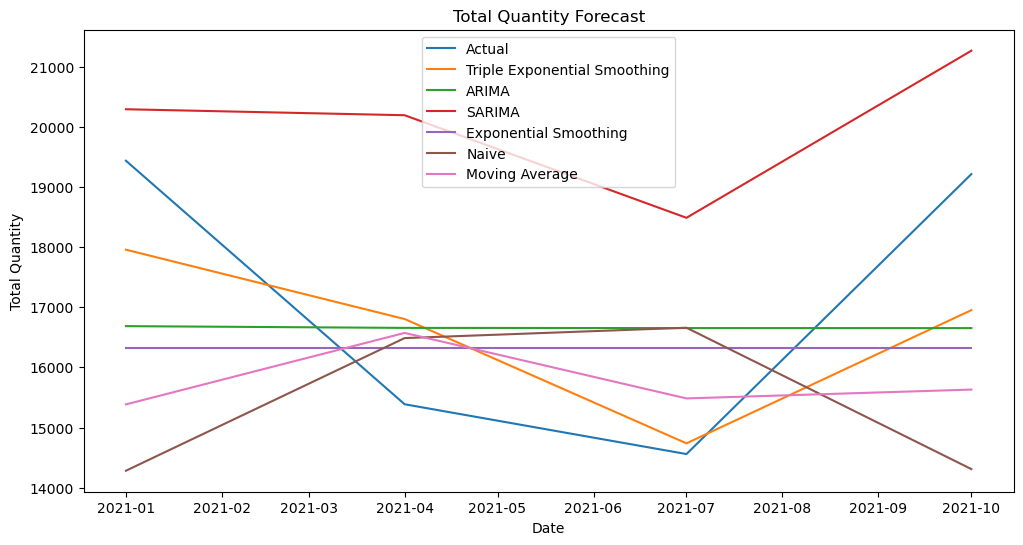

In [33]:
metrics_df_by_sku = []

# Assuming all_sku_ids is a list of SKU IDs available
for sku in all_sku_ids:
    print(f'Forecasting for SKU {sku}')
        
    for time_range in ['Quarter']:
        print(f'Forecasting for Time Range: {time_range}')
        forecasts, metrics = forecast_total_quantity_seasonal(df_cleaned, time_range, None, sku)
        
        for model, metric in metrics.items():
            metrics_df_by_sku.append({
                'SKU': sku,
                'District': 'All',
                'Time Range': time_range,
                'Model': model,
                'MAPE': metric['MAPE'],
                'MSE': metric['MSE'],
                'RMSE': metric['RMSE'],
                'MAD': metric['MAD']
            })
                
metrics_df_by_sku = pd.DataFrame(metrics_df_by_sku)

## Forecasting Metrics without District

The following table shows the forecast metrics for each SKU based on the different forecasting models and time ranges.

In [34]:
metrics_df_by_sku.set_index(['SKU', 'Time Range', 'Model'], inplace=True)
metrics_df_by_sku.drop(columns=['District'], inplace=True)

In [35]:
metrics_df_by_sku

MAPE           MSE  \
SKU  Time Range Model                                                  
568  Quarter    Triple Exponential Smoothing  0.196930  1.732778e+09   
                ARIMA                         0.205598  1.817086e+09   
                SARIMA                        0.411025  4.195628e+09   
                Exponential Smoothing         0.193524  2.259623e+09   
                Naive                         0.175451  2.098162e+09   
                Moving Average                0.188137  1.882419e+09   
578  Quarter    Triple Exponential Smoothing  0.140348  1.479076e+08   
                ARIMA                         0.187156  3.637932e+08   
                SARIMA                        0.764658  3.892494e+09   
                Exponential Smoothing         0.181413  3.236492e+08   
                Naive                         0.237960  4.747915e+08   
                Moving Average                0.210754  4.065214e+08   
1050 Quarter    Triple Exponential Smoothing  0.127534  1.084219e+08   
                ARIMA                         0.073349  5.795580e+07   
                SARIMA                        0.696946  3.045759e+09   
                Exponential Smoothing         0.075276  6.135548e+07   
                Naive                         0.228745  4.680768e+08   
                Moving Average                0.178673  2.515925e+08   
319  Quarter    Triple Exponential Smoothing  0.074296  8.270146e+07   
                ARIMA                         0.127871  1.004921e+08   
                SARIMA                        0.093131  3.472852e+07   
                Exponential Smoothing         0.129677  9.711901e+07   
                Naive                         0.166330  2.200155e+08   
                Moving Average                0.129510  1.446563e+08   
509  Quarter    Triple Exponential Smoothing  0.060901  6.672217e+06   
                ARIMA                         0.088113  1.955668e+07   
                SARIMA                        0.350648  1.510884e+08   
                Exponential Smoothing         0.089134  9.974222e+06   
                Naive                         0.179892  4.053620e+07   
                Moving Average                0.133181  2.302997e+07   
615  Quarter    Triple Exponential Smoothing  0.128108  2.240696e+07   
                ARIMA                         0.125158  1.975487e+07   
                SARIMA                        0.586644  3.794173e+08   
                Exponential Smoothing         0.126444  2.040720e+07   
                Naive                         0.193461  5.535171e+07   
                Moving Average                0.178865  4.115540e+07   
1018 Quarter    Triple Exponential Smoothing  0.074521  2.334594e+06   
                ARIMA                         0.125266  5.027900e+06   
                SARIMA                        0.183197  1.086159e+07   
                Exponential Smoothing         0.123113  5.510776e+06   
                Naive                         0.184028  1.405566e+07   
                Moving Average                0.133865  7.874874e+06   

                                                      RMSE           MAD  
SKU  Time Range Model                                                     
568  Quarter    Triple Exponential Smoothing  41626.651974  34741.672723  
                ARIMA                         42627.290057  34395.688004  
                SARIMA                        64773.666387  54410.524327  
                Exponential Smoothing         47535.486870  35206.899878  
                Naive                         45805.694155  32622.000000  
                Moving Average                43386.847667  33805.625000  
578  Quarter    Triple Exponential Smoothing  12161.725076  11044.060685  
                ARIMA                         19073.363405  16065.811270  
                SARIMA                        62389.852910  60779.770268  
                Exponential Smoothing         17990.2527

In [36]:
# make more readable for numbers, round to 3 digits
metrics_df_by_sku.round(3)

MAPE           MSE       RMSE  \
SKU  Time Range Model                                                          
568  Quarter    Triple Exponential Smoothing  0.197  1.732778e+09  41626.652   
                ARIMA                         0.206  1.817086e+09  42627.290   
                SARIMA                        0.411  4.195628e+09  64773.666   
                Exponential Smoothing         0.194  2.259623e+09  47535.487   
                Naive                         0.175  2.098162e+09  45805.694   
                Moving Average                0.188  1.882419e+09  43386.848   
578  Quarter    Triple Exponential Smoothing  0.140  1.479076e+08  12161.725   
                ARIMA                         0.187  3.637932e+08  19073.363   
                SARIMA                        0.765  3.892494e+09  62389.853   
                Exponential Smoothing         0.181  3.236492e+08  17990.253   
                Naive                         0.238  4.747915e+08  21789.710   
                Moving Average                0.211  4.065214e+08  20162.377   
1050 Quarter    Triple Exponential Smoothing  0.128  1.084219e+08  10412.582   
                ARIMA                         0.073  5.795580e+07   7612.870   
                SARIMA                        0.697  3.045759e+09  55188.391   
                Exponential Smoothing         0.075  6.135548e+07   7832.974   
                Naive                         0.229  4.680768e+08  21635.082   
                Moving Average                0.179  2.515925e+08  15861.666   
319  Quarter    Triple Exponential Smoothing  0.074  8.270146e+07   9094.034   
                ARIMA                         0.128  1.004921e+08  10024.573   
                SARIMA                        0.093  3.472852e+07   5893.091   
                Exponential Smoothing         0.130  9.711901e+07   9854.898   
                Naive                         0.166  2.200155e+08  14832.921   
                Moving Average                0.130  1.446563e+08  12027.316   
509  Quarter    Triple Exponential Smoothing  0.061  6.672217e+06   2583.064   
                ARIMA                         0.088  1.955668e+07   4422.294   
                SARIMA                        0.351  1.510884e+08  12291.801   
                Exponential Smoothing         0.089  9.974222e+06   3158.199   
                Naive                         0.180  4.053620e+07   6366.804   
                Moving Average                0.133  2.302997e+07   4798.955   
615  Quarter    Triple Exponential Smoothing  0.128  2.240696e+07   4733.599   
                ARIMA                         0.125  1.975487e+07   4444.645   
                SARIMA                        0.587  3.794173e+08  19478.637   
                Exponential Smoothing         0.126  2.040720e+07   4517.433   
                Naive                         0.193  5.535171e+07   7439.873   
                Moving Average                0.179  4.115540e+07   6415.247   
1018 Quarter    Triple Exponential Smoothing  0.075  2.334594e+06   1527.938   
                ARIMA                         0.125  5.027900e+06   2242.298   
                SARIMA                        0.183  1.086159e+07   3295.692   
                Exponential Smoothing         0.123  5.510776e+06   2347.504   
                Naive                         0.184  1.405566e+07   3749.087   
                Moving Average                0.134  7.874874e+06   2806.221   

                                                    MAD  
SKU  Time Range Model                                    
568  Quarter    Triple Exponential Smoothing  34741.673  
                ARIMA                         34395.688  
                SARIMA                        54410.524  
                Exponential Smoothing         35206.900  
                Naive                         32622.000  
                Moving Average                33805.625  
578  Quarter    Triple Exponential Smoothing  11044.061  
    

### Iterating over each SKU, District, and Time Range

Forecasting for SKU 568
Forecasting for District PENDİK
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03269D+00    |proj g|=  9.86213D-02

At iterate    5    f=  2.84415D+00    |proj g|=  3.39363D-02

At iterate   10    f=  2.82963D+00    |proj g|=  2.39213D-02

At iterate   15    f=  2.82539D+00    |proj g|=  7.26846D-03

At iterate   20    f=  2.82470D+00    |proj g|=  2.49241D-04

At iterate   25    f=  2.82469D+00    |proj g|=  1.46437D-04

At iterate   30    f=  2.82466D+00    |proj g|=  1.95777D-05

At iterate   35    f=  2.82466D+00    |proj g|=  5.34079D-05

At iterate   40    f=  2.82466D+00    |proj g|=  6.83873D-04

At iterate   45    f=  2.82437D+00    |proj g|=  4.98222D-03

At iterate   50    f=  2.82418D+00    |proj g|=  3.31667D-03

           * * *

Tit   = total number of iterations
Tnf  

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


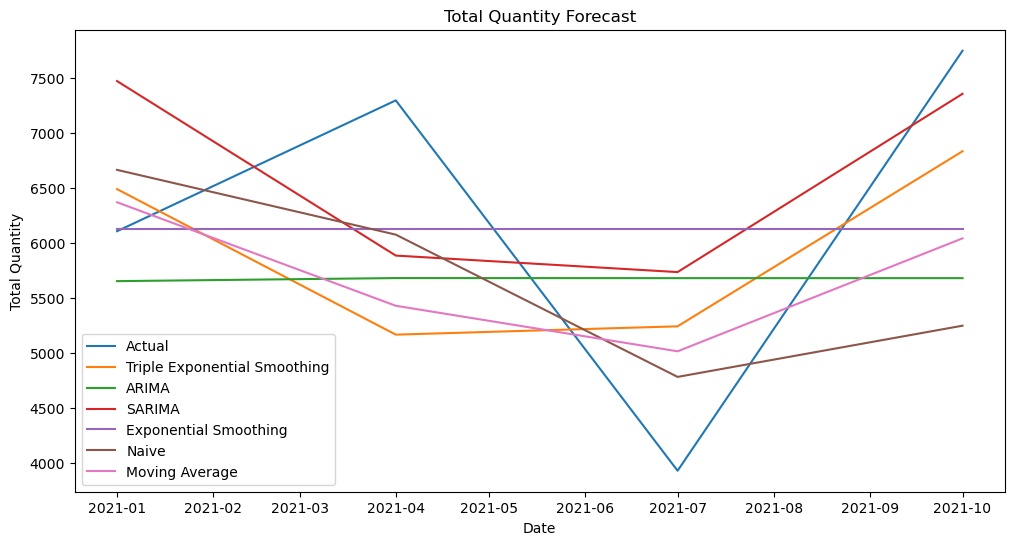

Forecasting for District GAZİOSMANPAŞA
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69880D+00    |proj g|=  1.75834D-01

At iterate    5    f=  2.56858D+00    |proj g|=  1.22817D-02

At iterate   10    f=  2.56525D+00    |proj g|=  3.39478D-03

At iterate   15    f=  2.56519D+00    |proj g|=  1.02168D-03

At iterate   20    f=  2.56430D+00    |proj g|=  1.49180D-02

At iterate   25    f=  2.51390D+00    |proj g|=  1.74500D-01

At iterate   30    f=  2.48295D+00    |proj g|=  2.47298D-02

At iterate   35    f=  2.47932D+00    |proj g|=  4.61992D-03

At iterate   40    f=  2.47840D+00    |proj g|=  1.58625D-02

At iterate   45    f=  2.47802D+00    |proj g|=  4.54866D-03

At iterate   50    f=  2.47780D+00    |proj g|=  1.92057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


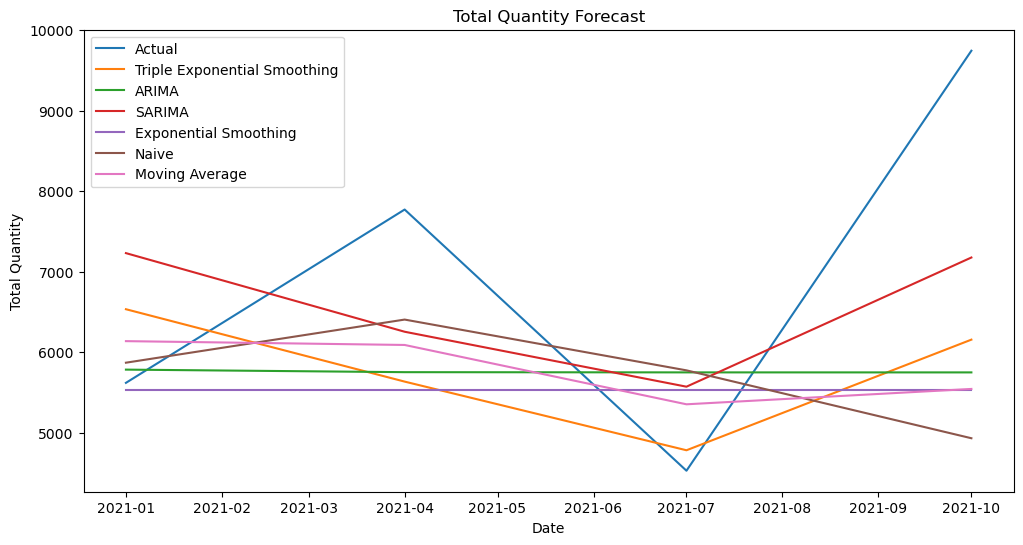

Forecasting for District KÜÇÜKÇEKMECE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30180D+00    |proj g|=  4.20487D-01

At iterate    5    f=  3.08141D+00    |proj g|=  2.64052D-02

At iterate   10    f=  3.07357D+00    |proj g|=  1.98850D-04

At iterate   15    f=  3.07351D+00    |proj g|=  1.70885D-03

At iterate   20    f=  3.07016D+00    |proj g|=  2.65473D-02

At iterate   25    f=  2.98230D+00    |proj g|=  2.93540D-01

At iterate   30    f=  2.91610D+00    |proj g|=  2.44760D-02

At iterate   35    f=  2.91123D+00    |proj g|=  4.80705D-03

At iterate   40    f=  2.90942D+00    |proj g|=  2.81443D-04

At iterate   45    f=  2.90467D+00    |proj g|=  4.76323D-04

At iterate   50    f=  2.90461D+00    |proj g|=  1.99896D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


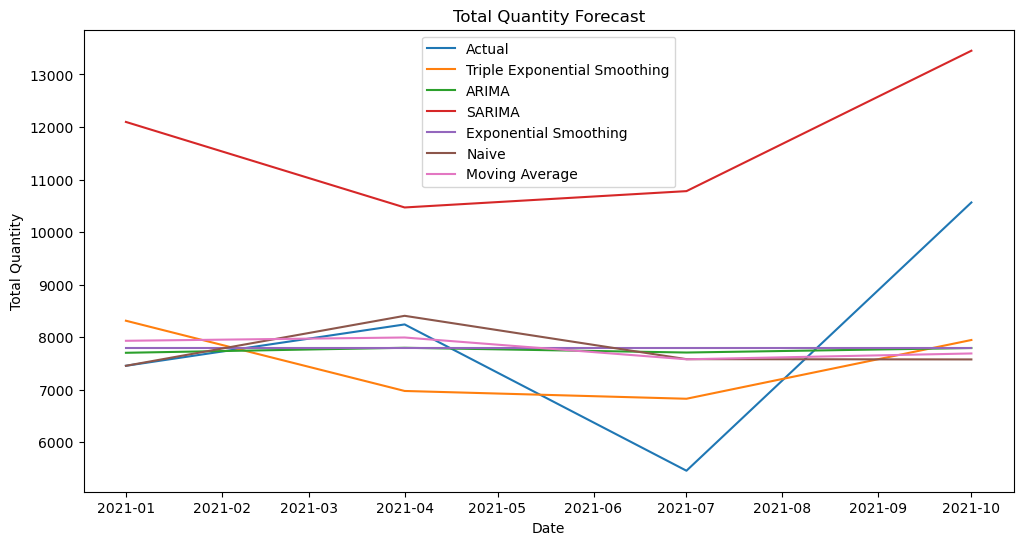

Forecasting for District ÜMRANİYE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30032D+00    |proj g|=  4.06334D-01

At iterate    5    f=  3.13247D+00    |proj g|=  2.16161D-02

At iterate   10    f=  3.12494D+00    |proj g|=  1.77389D-03

At iterate   15    f=  3.12493D+00    |proj g|=  5.57850D-04

At iterate   20    f=  3.12483D+00    |proj g|=  6.36496D-03

At iterate   25    f=  3.11881D+00    |proj g|=  3.06173D-02

At iterate   30    f=  2.84673D+00    |proj g|=  3.06578D-01

At iterate   35    f=  2.72490D+00    |proj g|=  1.37573D-01

At iterate   40    f=  2.68804D+00    |proj g|=  2.54466D-02

At iterate   45    f=  2.67915D+00    |proj g|=  4.48536D-02

At iterate   50    f=  2.67488D+00    |proj g|=  1.41184D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of fun

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


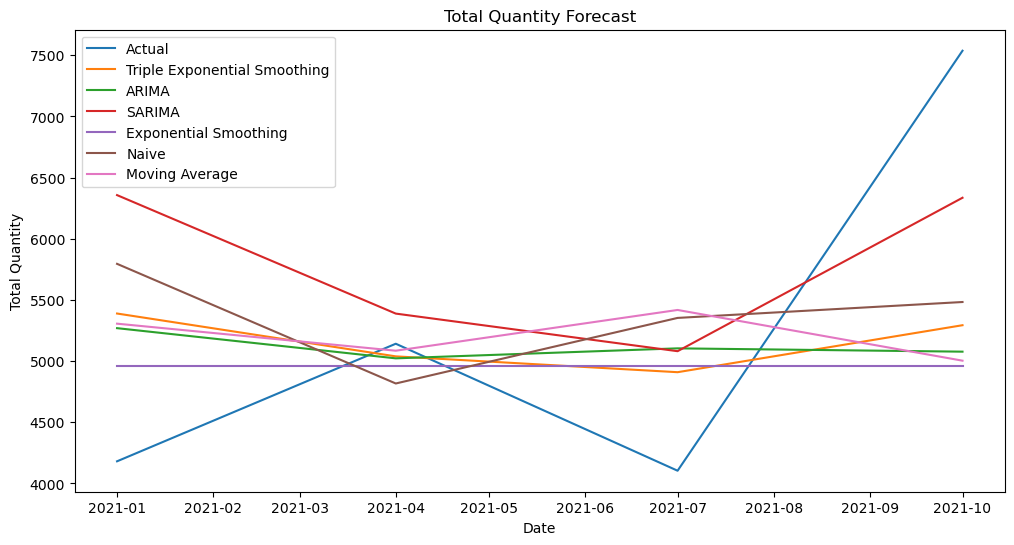

Forecasting for District FATİH
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14760D+00    |proj g|=  1.97544D-01

At iterate    5    f=  3.01111D+00    |proj g|=  7.23618D-02

At iterate   10    f=  2.96667D+00    |proj g|=  4.99468D-03

At iterate   15    f=  2.96551D+00    |proj g|=  2.08428D-04

At iterate   20    f=  2.96540D+00    |proj g|=  3.81697D-04

At iterate   25    f=  2.96540D+00    |proj g|=  2.90613D-05

At iterate   30    f=  2.96540D+00    |proj g|=  6.10937D-04

At iterate   35    f=  2.96509D+00    |proj g|=  8.55838D-03

At iterate   40    f=  2.96462D+00    |proj g|=  7.15290D-04

At iterate   45    f=  2.96457D+00    |proj g|=  2.85742D-04

At iterate   50    f=  2.96456D+00    |proj g|=  6.86368D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of functi

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


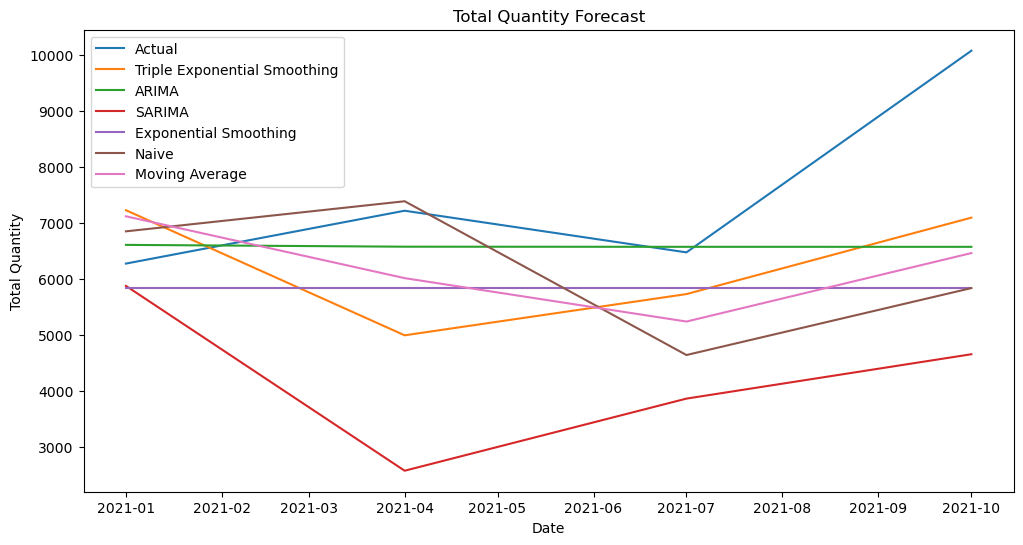

Forecasting for SKU 578
Forecasting for District PENDİK
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27850D+00    |proj g|=  2.05577D-01

At iterate    5    f=  3.06784D+00    |proj g|=  1.52605D-02

At iterate   10    f=  3.04648D+00    |proj g|=  3.13934D-02

At iterate   15    f=  3.02791D+00    |proj g|=  1.35323D-02

At iterate   20    f=  3.01235D+00    |proj g|=  7.07864D-03

At iterate   25    f=  3.01056D+00    |proj g|=  1.38300D-03

At iterate   30    f=  3.01040D+00    |proj g|=  1.59460D-04

At iterate   35    f=  3.01035D+00    |proj g|=  1.99248D-03

At iterate   40    f=  2.96526D+00    |proj g|=  1.24348D-01

At iterate   45    f=  2.94619D+00    |proj g|=  1.20492D-02

At iterate   50    f=  2.93939D+00    |proj g|=  5.95777D-03

           * * *

Tit   = total number of iterations
Tnf  

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


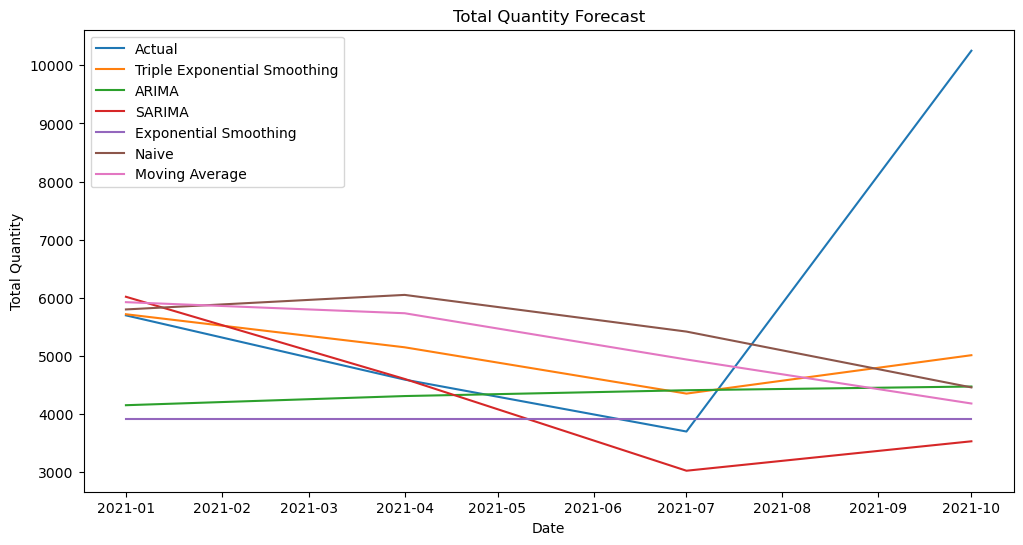

Forecasting for District GAZİOSMANPAŞA
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19700D+00    |proj g|=  2.63740D-01

At iterate    5    f=  3.05927D+00    |proj g|=  1.97055D-02

At iterate   10    f=  3.05051D+00    |proj g|=  1.26307D-03

At iterate   15    f=  3.05043D+00    |proj g|=  5.38656D-04

At iterate   20    f=  3.05021D+00    |proj g|=  6.88427D-03

At iterate   25    f=  3.02433D+00    |proj g|=  5.76973D-02

At iterate   30    f=  2.83193D+00    |proj g|=  2.41540D-01

At iterate   35    f=  2.72640D+00    |proj g|=  2.48319D-02

At iterate   40    f=  2.69471D+00    |proj g|=  3.48307D-02

At iterate   45    f=  2.67757D+00    |proj g|=  5.03939D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.


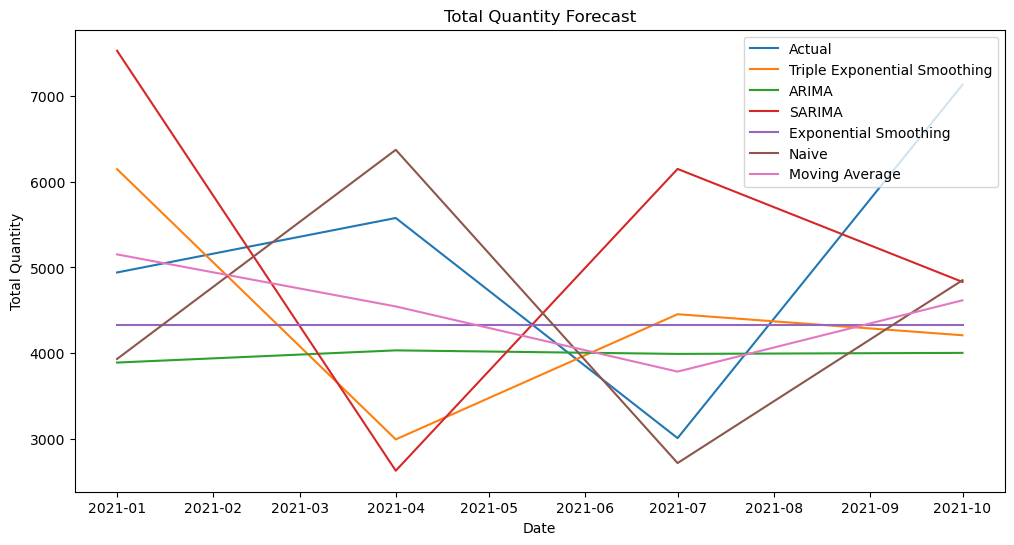

Forecasting for District KÜÇÜKÇEKMECE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41152D+00    |proj g|=  6.55130D-01

At iterate    5    f=  3.21017D+00    |proj g|=  5.24350D-02

At iterate   10    f=  3.19743D+00    |proj g|=  3.12209D-03

At iterate   15    f=  3.19726D+00    |proj g|=  1.65243D-04

At iterate   20    f=  3.19722D+00    |proj g|=  1.91887D-03

At iterate   25    f=  3.17685D+00    |proj g|=  6.82645D-02

At iterate   30    f=  2.96909D+00    |proj g|=  1.92678D-02

At iterate   35    f=  2.95723D+00    |proj g|=  8.75633D-03

At iterate   40    f=  2.95350D+00    |proj g|=  4.68982D-03

At iterate   45    f=  2.95168D+00    |proj g|=  7.95812D-03


 This problem is unconstrained.



At iterate   50    f=  2.95109D+00    |proj g|=  4.49935D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64      1     0     0   4.499D-03   2.951D+00
  F =   2.9510914007337110     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


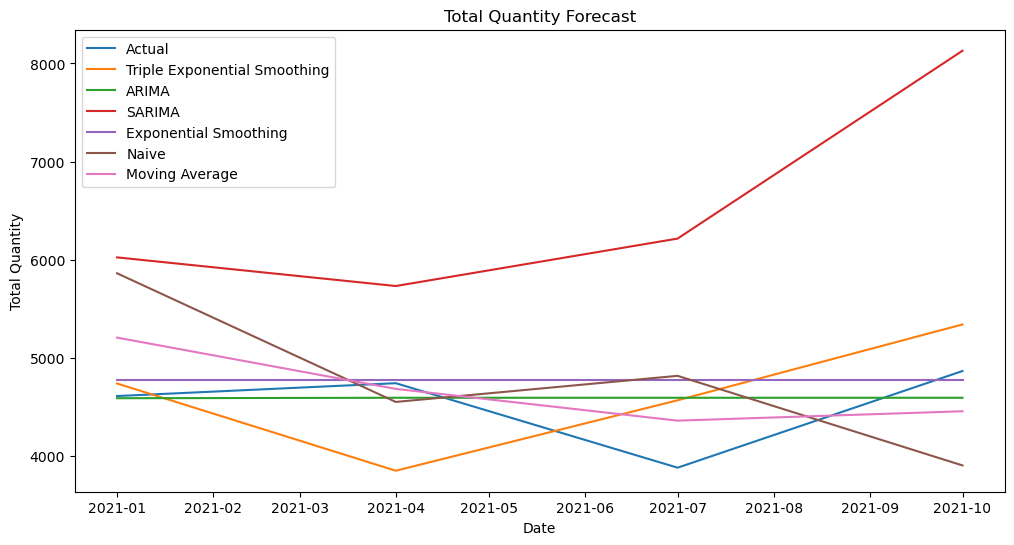

Forecasting for District ÜMRANİYE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34791D+00    |proj g|=  2.80033D-01

At iterate    5    f=  3.16932D+00    |proj g|=  2.16799D-02

At iterate   10    f=  3.16242D+00    |proj g|=  2.09750D-03

At iterate   15    f=  3.16237D+00    |proj g|=  3.70436D-04

At iterate   20    f=  3.16219D+00    |proj g|=  3.76172D-03

At iterate   25    f=  3.00022D+00    |proj g|=  1.62733D-02

At iterate   30    f=  2.98781D+00    |proj g|=  1.80543D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final f

 This problem is unconstrained.


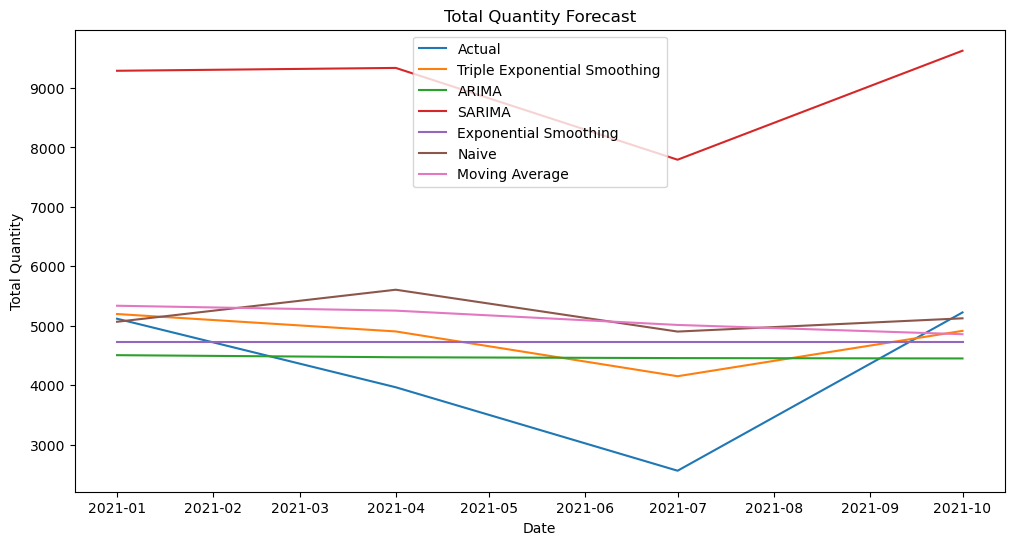

Forecasting for District FATİH
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91357D+00    |proj g|=  1.20604D-01

At iterate    5    f=  2.76892D+00    |proj g|=  2.64381D-02

At iterate   10    f=  2.75988D+00    |proj g|=  6.32341D-03

At iterate   15    f=  2.75916D+00    |proj g|=  1.37836D-03

At iterate   20    f=  2.75913D+00    |proj g|=  3.70812D-04

At iterate   25    f=  2.75870D+00    |proj g|=  1.03383D-02

At iterate   30    f=  2.74278D+00    |proj g|=  2.60814D-02

At iterate   35    f=  2.73715D+00    |proj g|=  2.15375D-02

At iterate   40    f=  2.73450D+00    |proj g|=  5.76971D-03

At iterate   45    f=  2.73338D+00    |proj g|=  5.38256D-03

At iterate   50    f=  2.73295D+00    |proj g|=  2.36939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of functi

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


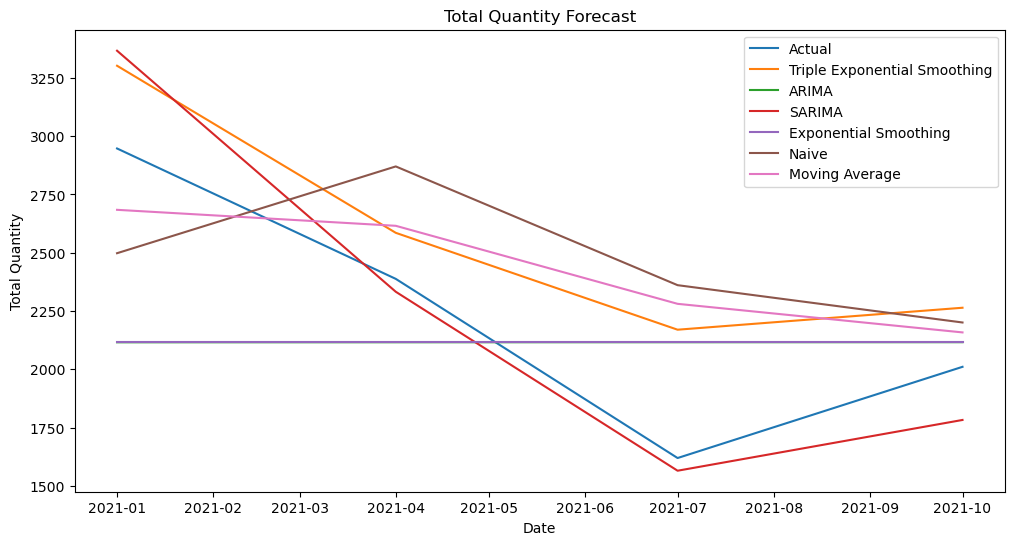

Forecasting for SKU 1050
Forecasting for District PENDİK
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13020D+00    |proj g|=  7.89996D-02

At iterate    5    f=  3.08557D+00    |proj g|=  2.54356D-02

At iterate   10    f=  3.06422D+00    |proj g|=  1.95791D-02

At iterate   15    f=  3.04799D+00    |proj g|=  8.67210D-04

At iterate   20    f=  3.04773D+00    |proj g|=  4.96232D-04

At iterate   25    f=  3.04718D+00    |proj g|=  4.67037D-03

At iterate   30    f=  3.03383D+00    |proj g|=  4.55095D-03

At iterate   35    f=  3.02789D+00    |proj g|=  2.90899D-03

At iterate   40    f=  3.02765D+00    |proj g|=  6.65917D-04

At iterate   45    f=  3.02764D+00    |proj g|=  8.06987D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number 

 This problem is unconstrained.


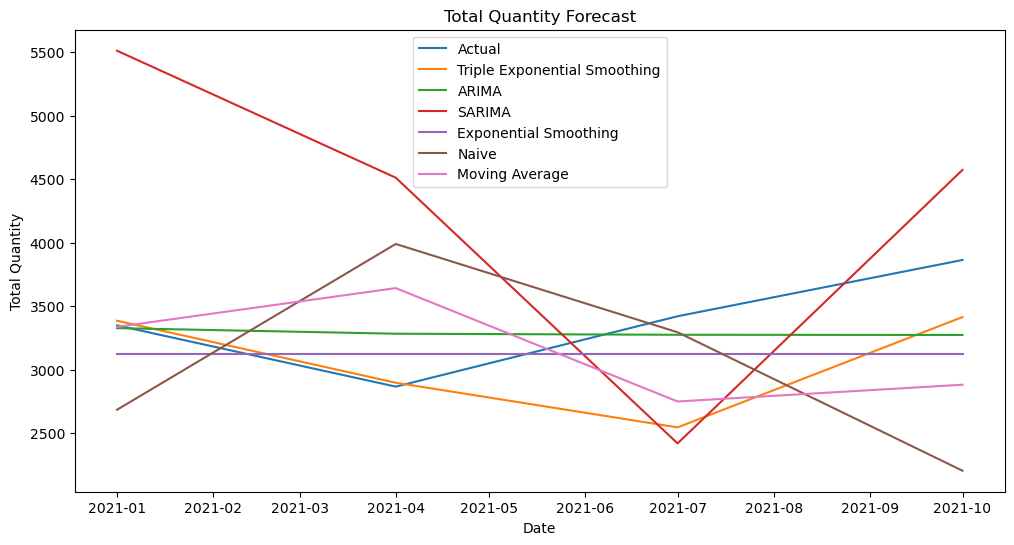

Forecasting for District GAZİOSMANPAŞA
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53162D+00    |proj g|=  2.81896D-01

At iterate    5    f=  3.41272D+00    |proj g|=  1.56340D-02

At iterate   10    f=  3.40281D+00    |proj g|=  3.00552D-03

At iterate   15    f=  3.40184D+00    |proj g|=  1.21312D-03

At iterate   20    f=  3.40166D+00    |proj g|=  5.70076D-04

At iterate   25    f=  3.40136D+00    |proj g|=  1.47008D-03

At iterate   30    f=  3.36383D+00    |proj g|=  2.00802D-02

At iterate   35    f=  3.36155D+00    |proj g|=  2.80602D-03

At iterate   40    f=  3.36145D+00    |proj g|=  3.27856D-03

At iterate   45    f=  3.35982D+00    |proj g|=  2.81522D-03

At iterate   50    f=  3.35937D+00    |proj g|=  3.51373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


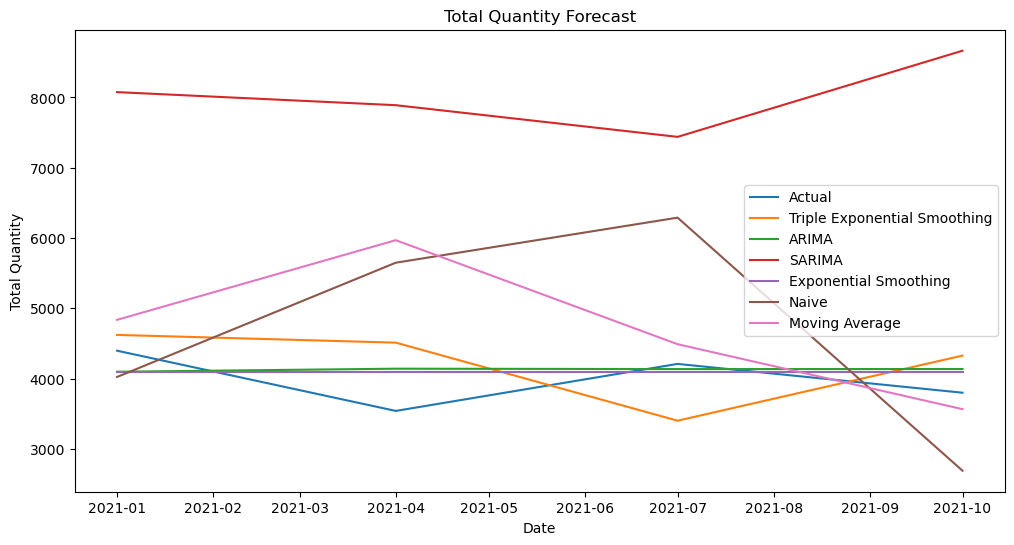

Forecasting for District KÜÇÜKÇEKMECE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26878D+00    |proj g|=  1.66514D-01

At iterate    5    f=  3.18321D+00    |proj g|=  6.57032D-03

At iterate   10    f=  3.17754D+00    |proj g|=  7.04047D-03

At iterate   15    f=  3.17507D+00    |proj g|=  1.77065D-03

At iterate   20    f=  3.17506D+00    |proj g|=  4.37081D-05

At iterate   25    f=  3.17501D+00    |proj g|=  1.64003D-03

At iterate   30    f=  3.17120D+00    |proj g|=  1.90587D-02

At iterate   35    f=  3.16864D+00    |proj g|=  3.89133D-04

At iterate   40    f=  3.16851D+00    |proj g|=  2.00240D-03

At iterate   45    f=  3.16846D+00    |proj g|=  4.26265D-04

At iterate   50    f=  3.16844D+00    |proj g|=  5.80926D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


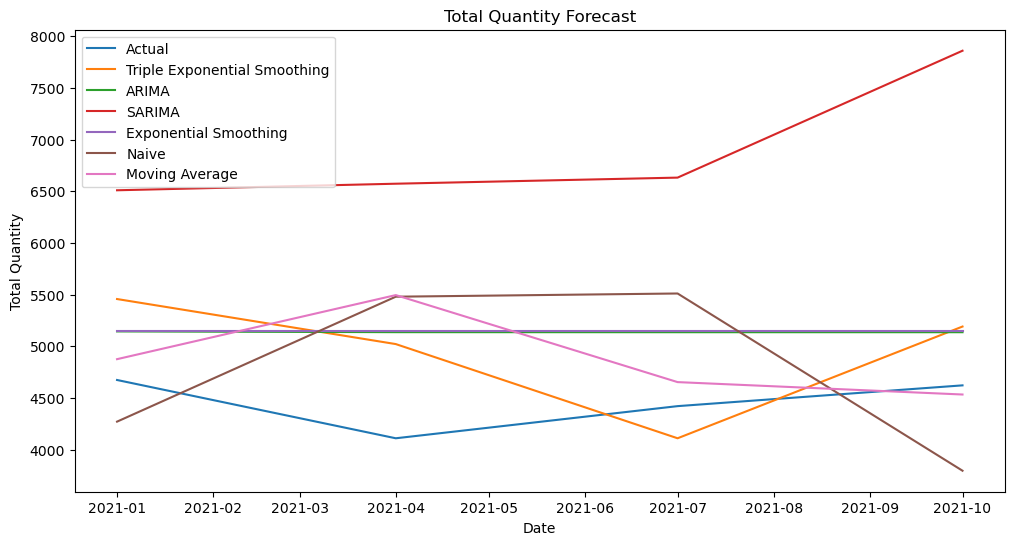

Forecasting for District ÜMRANİYE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03613D+00    |proj g|=  1.69090D-01

At iterate    5    f=  2.99314D+00    |proj g|=  1.86305D-02

At iterate   10    f=  2.98826D+00    |proj g|=  1.41389D-03

At iterate   15    f=  2.98802D+00    |proj g|=  8.33795D-05

At iterate   20    f=  2.98802D+00    |proj g|=  6.69530D-05

At iterate   25    f=  2.98797D+00    |proj g|=  2.62513D-03

At iterate   30    f=  2.98656D+00    |proj g|=  5.76000D-03

At iterate   35    f=  2.98614D+00    |proj g|=  9.19533D-04

At iterate   40    f=  2.98609D+00    |proj g|=  4.59960D-04

At iterate   45    f=  2.98602D+00    |proj g|=  8.43432D-05

At iterate   50    f=  2.98602D+00    |proj g|=  1.46624D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of fun

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


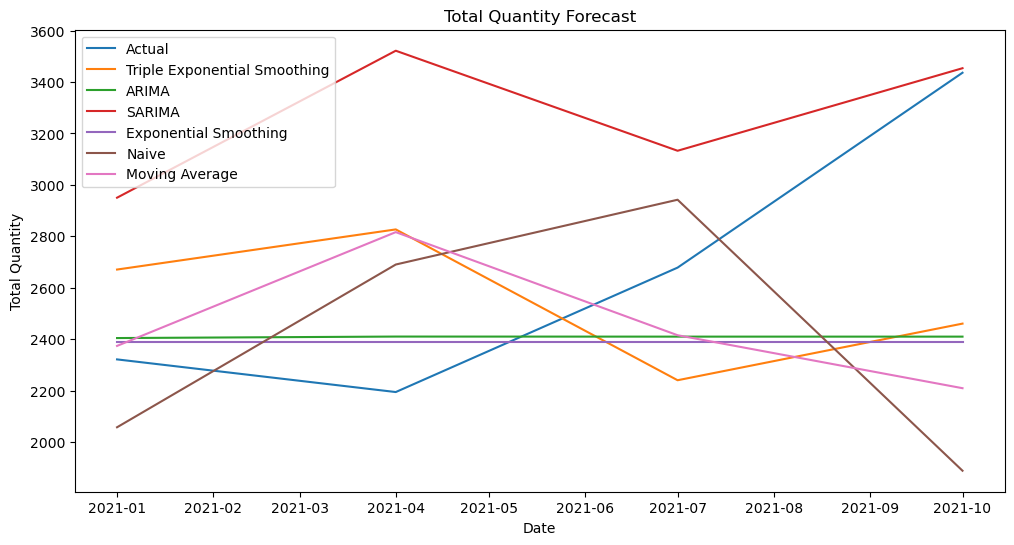

Forecasting for District FATİH
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24981D+00    |proj g|=  4.35234D-01

At iterate    5    f=  2.94713D+00    |proj g|=  2.55075D-02

At iterate   10    f=  2.93712D+00    |proj g|=  3.01834D-03

At iterate   15    f=  2.93697D+00    |proj g|=  1.87050D-04

At iterate   20    f=  2.93677D+00    |proj g|=  3.46451D-03

At iterate   25    f=  2.92144D+00    |proj g|=  2.06225D-02

At iterate   30    f=  2.89385D+00    |proj g|=  1.16234D-02

At iterate   35    f=  2.88926D+00    |proj g|=  1.21840D-03

At iterate   40    f=  2.88823D+00    |proj g|=  1.60521D-03

At iterate   45    f=  2.88767D+00    |proj g|=  9.62079D-04

At iterate   50    f=  2.88743D+00    |proj g|=  7.59660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of functi

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


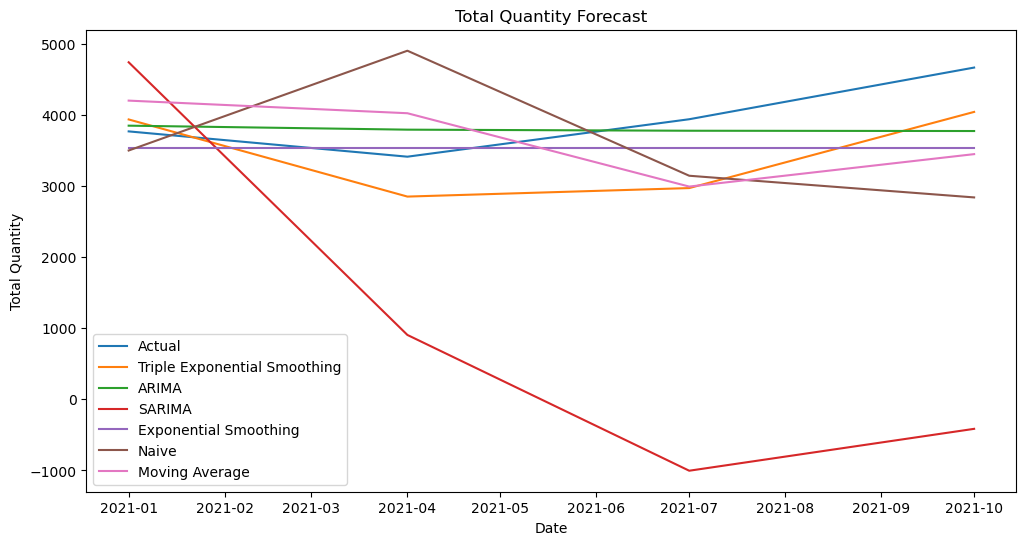

Forecasting for SKU 319
Forecasting for District PENDİK
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57324D+00    |proj g|=  2.90542D-02

At iterate    5    f=  2.43601D+00    |proj g|=  2.34554D-02

At iterate   10    f=  2.43038D+00    |proj g|=  3.83715D-03

At iterate   15    f=  2.42984D+00    |proj g|=  2.53066D-03

At iterate   20    f=  2.42980D+00    |proj g|=  1.19072D-04

At iterate   25    f=  2.42979D+00    |proj g|=  2.72175D-04

At iterate   30    f=  2.42978D+00    |proj g|=  1.31981D-03

At iterate   35    f=  2.42940D+00    |proj g|=  1.34315D-02

At iterate   40    f=  2.42840D+00    |proj g|=  3.66215D-03

At iterate   45    f=  2.42792D+00    |proj g|=  4.88169D-03

At iterate   50    f=  2.42770D+00    |proj g|=  9.66792D-04

           * * *

Tit   = total number of iterations
Tnf  

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


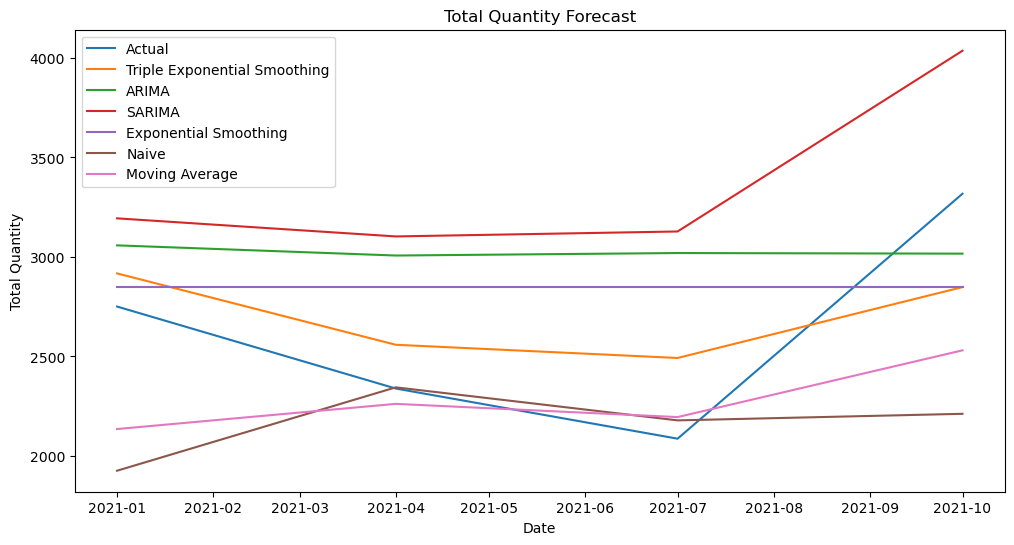

Forecasting for District GAZİOSMANPAŞA
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71479D+00    |proj g|=  3.38977D-01

At iterate    5    f=  2.54269D+00    |proj g|=  3.51712D-02

At iterate   10    f=  2.52163D+00    |proj g|=  1.14766D-02

At iterate   15    f=  2.51905D+00    |proj g|=  5.94315D-04

At iterate   20    f=  2.51831D+00    |proj g|=  2.63175D-03

At iterate   25    f=  2.50051D+00    |proj g|=  1.08331D-03

At iterate   30    f=  2.50043D+00    |proj g|=  1.46109D-03

At iterate   35    f=  2.49704D+00    |proj g|=  1.15279D-02

At iterate   40    f=  2.49428D+00    |proj g|=  5.24576D-03

At iterate   45    f=  2.49100D+00    |proj g|=  3.90756D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.


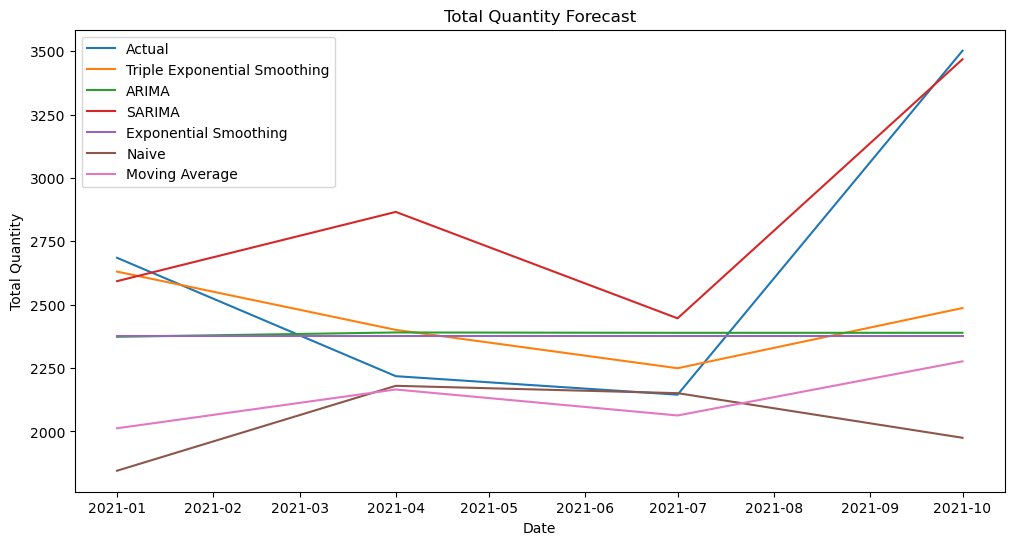

Forecasting for District KÜÇÜKÇEKMECE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50465D+00    |proj g|=  3.18981D-01

At iterate    5    f=  2.36883D+00    |proj g|=  9.23917D-03

At iterate   10    f=  2.36735D+00    |proj g|=  1.81117D-03

At iterate   15    f=  2.34343D+00    |proj g|=  2.78990D-02

At iterate   20    f=  2.32145D+00    |proj g|=  3.44550D-02

At iterate   25    f=  2.28101D+00    |proj g|=  1.81591D-02

At iterate   30    f=  2.26886D+00    |proj g|=  3.66102D-03

At iterate   35    f=  2.26750D+00    |proj g|=  4.45700D-04

At iterate   40    f=  2.26738D+00    |proj g|=  5.86659D-04

At iterate   45    f=  2.26736D+00    |proj g|=  7.98202D-05

At iterate   50    f=  2.26656D+00    |proj g|=  9.82011D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


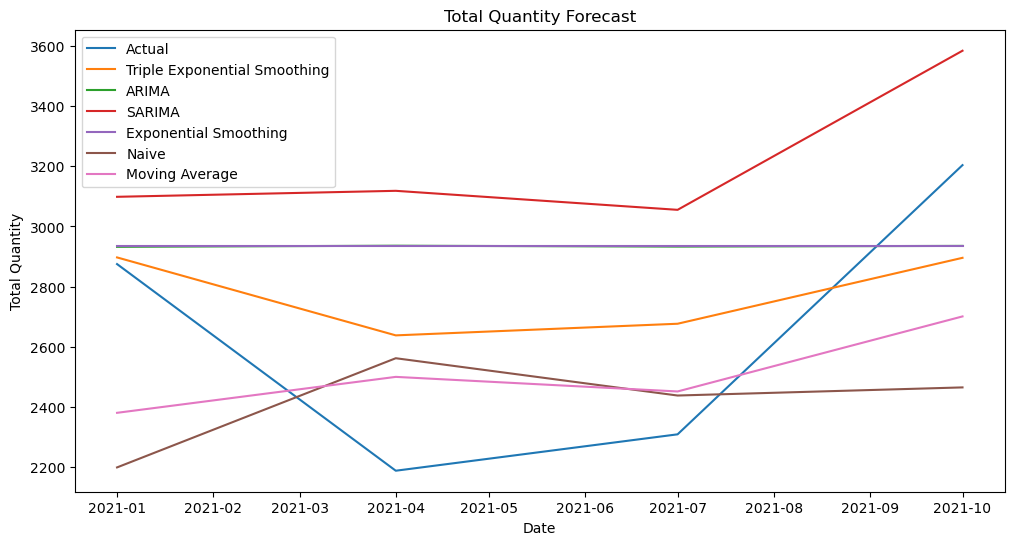

Forecasting for District ÜMRANİYE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66946D+00    |proj g|=  5.08215D-02

At iterate    5    f=  2.60501D+00    |proj g|=  1.69986D-03

At iterate   10    f=  2.60466D+00    |proj g|=  1.54283D-03

At iterate   15    f=  2.60462D+00    |proj g|=  1.27340D-04

At iterate   20    f=  2.60462D+00    |proj g|=  4.45033D-04

At iterate   25    f=  2.60443D+00    |proj g|=  4.18108D-03

At iterate   30    f=  2.60366D+00    |proj g|=  2.95152D-03

At iterate   35    f=  2.60357D+00    |proj g|=  1.12609D-03

At iterate   40    f=  2.60350D+00    |proj g|=  4.10927D-04

At iterate   45    f=  2.60348D+00    |proj g|=  2.21096D-04

At iterate   50    f=  2.60348D+00    |proj g|=  4.26481D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of fun

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


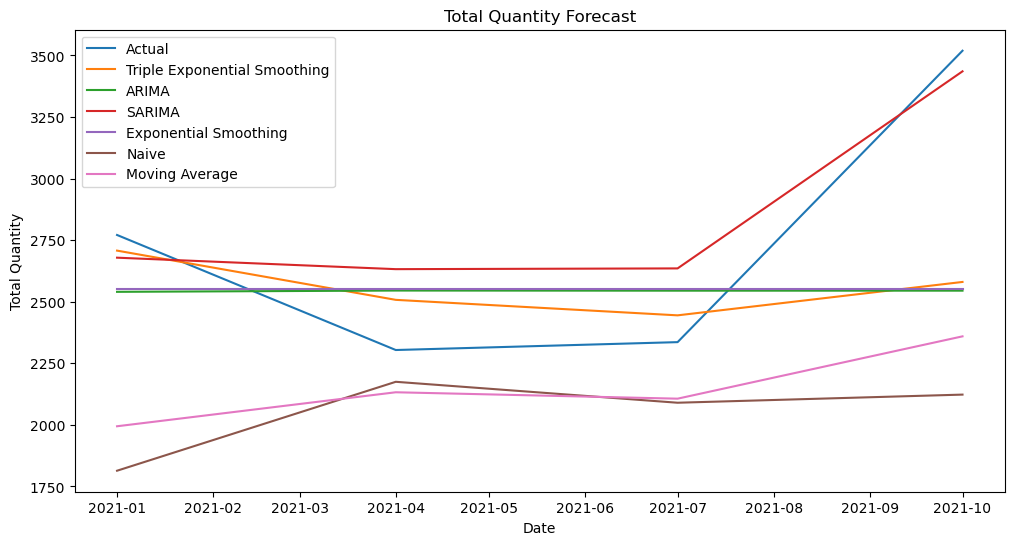

Forecasting for District FATİH
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66451D+00    |proj g|=  2.17566D-01

At iterate    5    f=  2.59153D+00    |proj g|=  6.50172D-03

At iterate   10    f=  2.59112D+00    |proj g|=  9.31357D-04

At iterate   15    f=  2.55590D+00    |proj g|=  9.71821D-02

At iterate   20    f=  2.54286D+00    |proj g|=  3.73273D-04

At iterate   25    f=  2.54165D+00    |proj g|=  4.73228D-03

At iterate   30    f=  2.50974D+00    |proj g|=  2.46888D-02

At iterate   35    f=  2.49570D+00    |proj g|=  1.07598D-02

At iterate   40    f=  2.49117D+00    |proj g|=  2.30768D-03

At iterate   45    f=  2.48992D+00    |proj g|=  1.83031D-03

At iterate   50    f=  2.48940D+00    |proj g|=  4.42135D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of functi

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


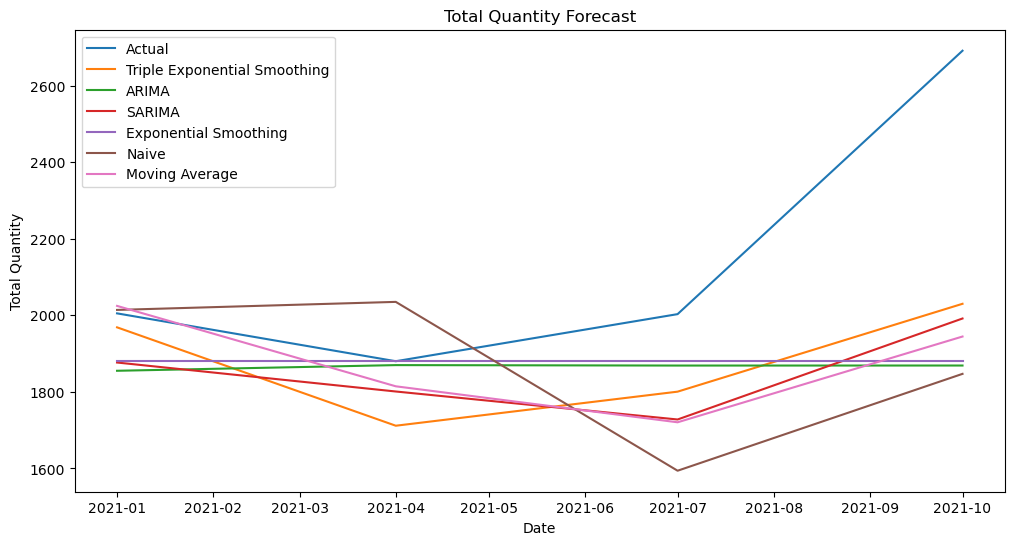

Forecasting for SKU 509
Forecasting for District PENDİK
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79211D+00    |proj g|=  3.06490D-01

At iterate    5    f=  2.62735D+00    |proj g|=  5.25269D-02

At iterate   10    f=  2.60148D+00    |proj g|=  2.09610D-02

At iterate   15    f=  2.58823D+00    |proj g|=  3.16884D-02

At iterate   20    f=  2.58268D+00    |proj g|=  3.15280D-03

At iterate   25    f=  2.58248D+00    |proj g|=  1.91223D-04

At iterate   30    f=  2.58245D+00    |proj g|=  2.10626D-04

At iterate   35    f=  2.58142D+00    |proj g|=  1.22138D-02

At iterate   40    f=  2.57300D+00    |proj g|=  2.92697D-03

At iterate   45    f=  2.57164D+00    |proj g|=  5.87518D-03

At iterate   50    f=  2.57092D+00    |proj g|=  5.36251D-03

           * * *

Tit   = total number of iterations
Tnf  

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


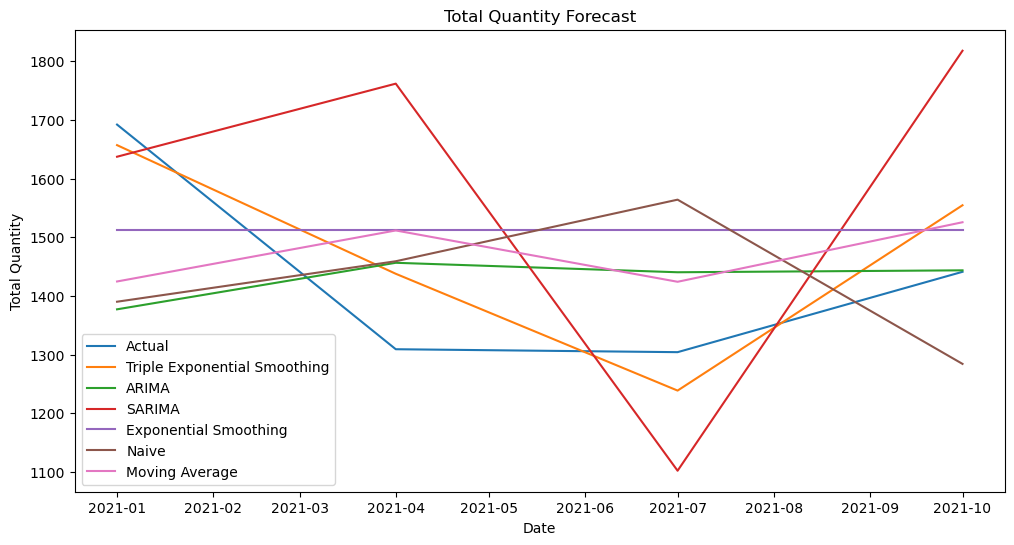

Forecasting for District GAZİOSMANPAŞA
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67155D+00    |proj g|=  1.65478D-01

At iterate    5    f=  2.56992D+00    |proj g|=  3.91864D-03

At iterate   10    f=  2.56882D+00    |proj g|=  5.69993D-04

At iterate   15    f=  2.56713D+00    |proj g|=  1.20949D-02

At iterate   20    f=  2.50945D+00    |proj g|=  3.13958D-02

At iterate   25    f=  2.50347D+00    |proj g|=  3.16110D-02

At iterate   30    f=  2.50277D+00    |proj g|=  1.64271D-02

At iterate   35    f=  2.50193D+00    |proj g|=  7.97835D-03

At iterate   40    f=  2.50155D+00    |proj g|=  5.19278D-03

At iterate   45    f=  2.50136D+00    |proj g|=  2.37488D-03


 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.50125D+00    |proj g|=  2.49937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   2.499D-03   2.501D+00
  F =   2.5012490297057202     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


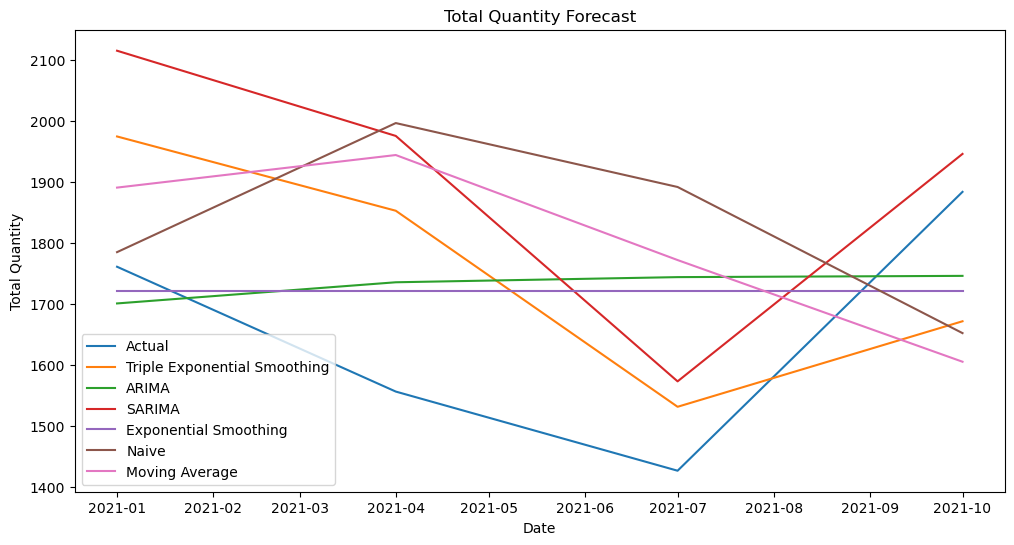

Forecasting for District KÜÇÜKÇEKMECE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70705D+00    |proj g|=  1.97082D-01

At iterate    5    f=  2.61234D+00    |proj g|=  1.07393D-02

At iterate   10    f=  2.59925D+00    |proj g|=  3.65554D-03

At iterate   15    f=  2.59892D+00    |proj g|=  5.84951D-05

At iterate   20    f=  2.59892D+00    |proj g|=  5.16589D-04

At iterate   25    f=  2.59891D+00    |proj g|=  9.74895D-05

At iterate   30    f=  2.59888D+00    |proj g|=  2.15211D-03

At iterate   35    f=  2.59810D+00    |proj g|=  3.02654D-03

At iterate   40    f=  2.59644D+00    |proj g|=  8.10848D-03

At iterate   45    f=  2.59495D+00    |proj g|=  5.20104D-03

At iterate   50    f=  2.59447D+00    |proj g|=  4.98055D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


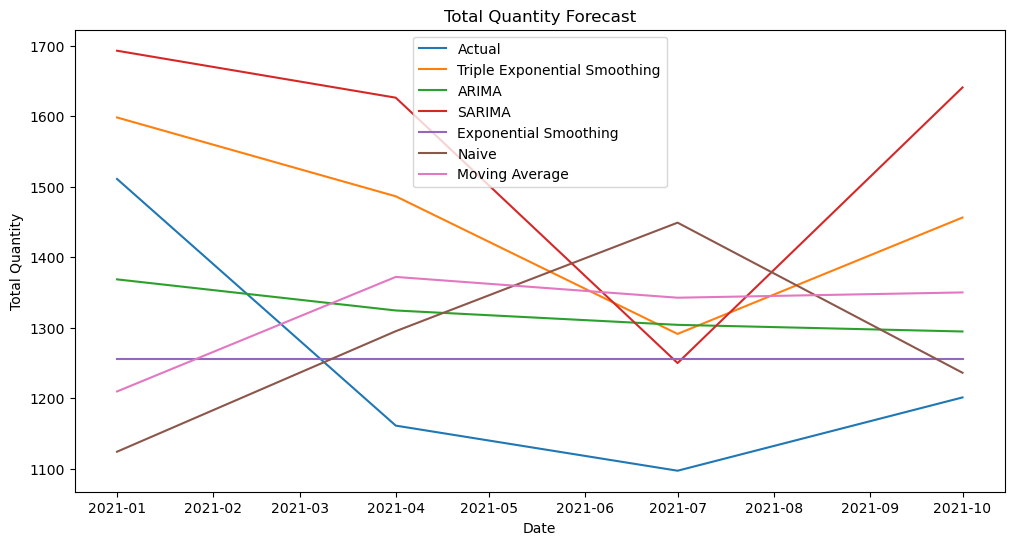

Forecasting for District ÜMRANİYE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94516D+00    |proj g|=  2.33984D-01

At iterate    5    f=  2.78416D+00    |proj g|=  8.77025D-03

At iterate   10    f=  2.78351D+00    |proj g|=  3.88235D-04

At iterate   15    f=  2.78317D+00    |proj g|=  6.49824D-03

At iterate   20    f=  2.75022D+00    |proj g|=  9.91630D-02

At iterate   25    f=  2.66745D+00    |proj g|=  7.24839D-03

At iterate   30    f=  2.66512D+00    |proj g|=  2.94140D-03

At iterate   35    f=  2.66467D+00    |proj g|=  1.92142D-03

At iterate   40    f=  2.66422D+00    |proj g|=  4.89321D-04

At iterate   45    f=  2.66395D+00    |proj g|=  4.46826D-04

At iterate   50    f=  2.66373D+00    |proj g|=  8.00325D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of fun

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


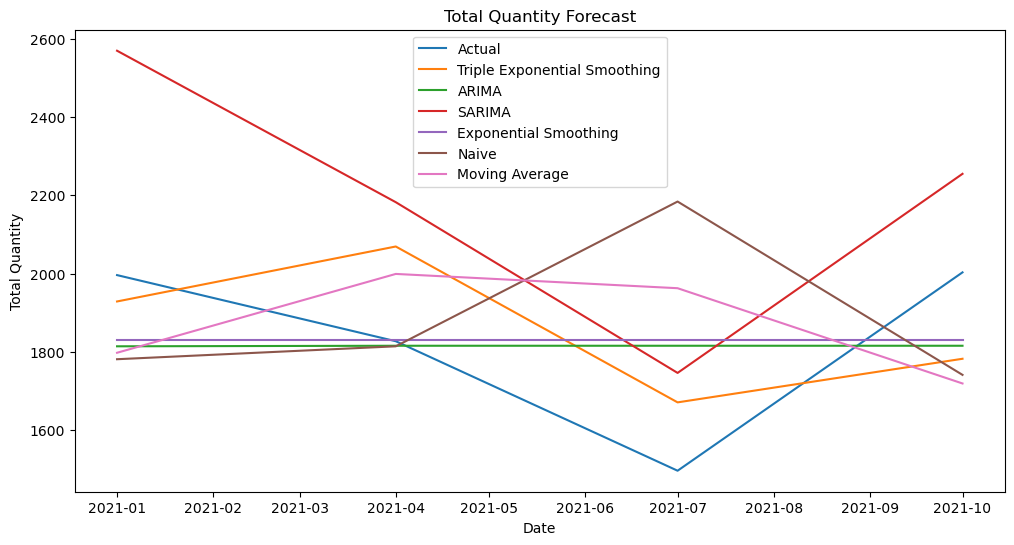

Forecasting for District FATİH
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70504D+00    |proj g|=  1.03360D-01

At iterate    5    f=  2.60245D+00    |proj g|=  3.05748D-03

At iterate   10    f=  2.60185D+00    |proj g|=  1.18712D-03

At iterate   15    f=  2.59664D+00    |proj g|=  1.84601D-02

At iterate   20    f=  2.50312D+00    |proj g|=  3.87693D-02

At iterate   25    f=  2.46918D+00    |proj g|=  3.36286D-02

At iterate   30    f=  2.45996D+00    |proj g|=  4.79374D-03

At iterate   35    f=  2.45654D+00    |proj g|=  4.21744D-03

At iterate   40    f=  2.45532D+00    |proj g|=  1.33817D-03

At iterate   45    f=  2.45469D+00    |proj g|=  2.79430D-04

At iterate   50    f=  2.45449D+00    |proj g|=  1.02636D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of functi

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


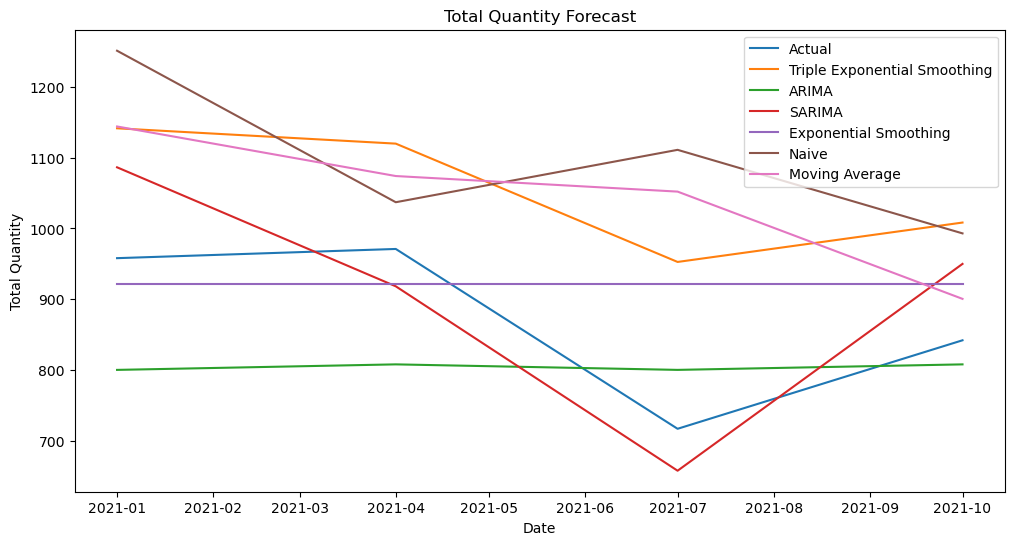

Forecasting for SKU 615
Forecasting for District PENDİK
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82994D+00    |proj g|=  1.36231D-01

At iterate    5    f=  2.69386D+00    |proj g|=  6.55226D-03

At iterate   10    f=  2.69300D+00    |proj g|=  1.71639D-03

At iterate   15    f=  2.68412D+00    |proj g|=  2.62778D-02

At iterate   20    f=  2.58683D+00    |proj g|=  7.32312D-02

At iterate   25    f=  2.56135D+00    |proj g|=  7.51245D-03

At iterate   30    f=  2.56025D+00    |proj g|=  1.00724D-03

At iterate   35    f=  2.55950D+00    |proj g|=  9.43196D-04

At iterate   40    f=  2.55938D+00    |proj g|=  1.79902D-04

At iterate   45    f=  2.55936D+00    |proj g|=  7.03221D-05

At iterate   50    f=  2.55935D+00    |proj g|=  1.82706D-04

           * * *

Tit   = total number of iterations
Tnf  

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


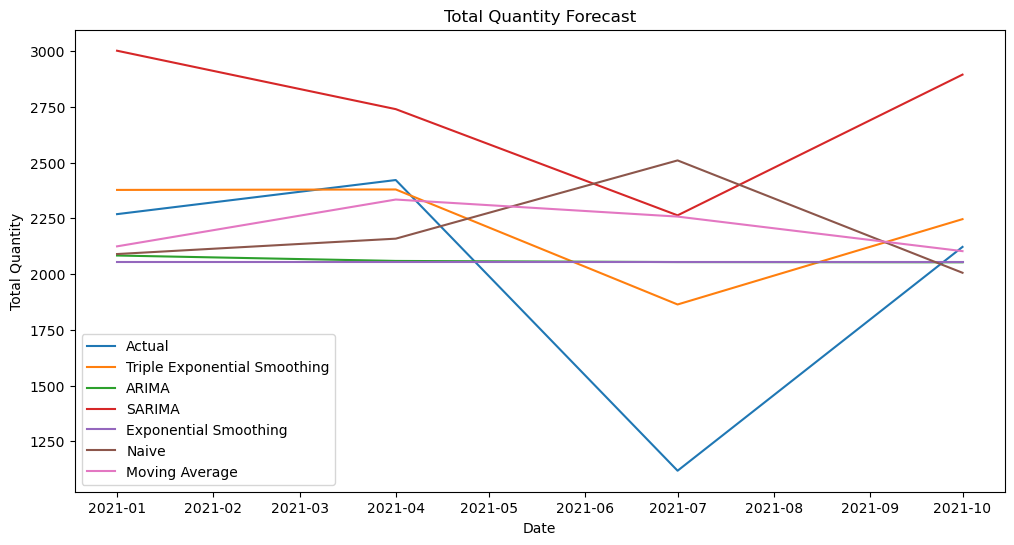

Forecasting for District GAZİOSMANPAŞA
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86588D+00    |proj g|=  1.73672D-01

At iterate    5    f=  2.76659D+00    |proj g|=  4.36918D-03

At iterate   10    f=  2.76412D+00    |proj g|=  3.57474D-04

At iterate   15    f=  2.76399D+00    |proj g|=  3.43694D-03

At iterate   20    f=  2.75003D+00    |proj g|=  2.93231D-02

At iterate   25    f=  2.71314D+00    |proj g|=  2.24896D-02

At iterate   30    f=  2.65214D+00    |proj g|=  1.06788D-02

At iterate   35    f=  2.64961D+00    |proj g|=  1.26522D-02

At iterate   40    f=  2.64811D+00    |proj g|=  1.48022D-03

At iterate   45    f=  2.64759D+00    |proj g|=  7.14695D-04

At iterate   50    f=  2.64714D+00    |proj g|=  2.69794D-04

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


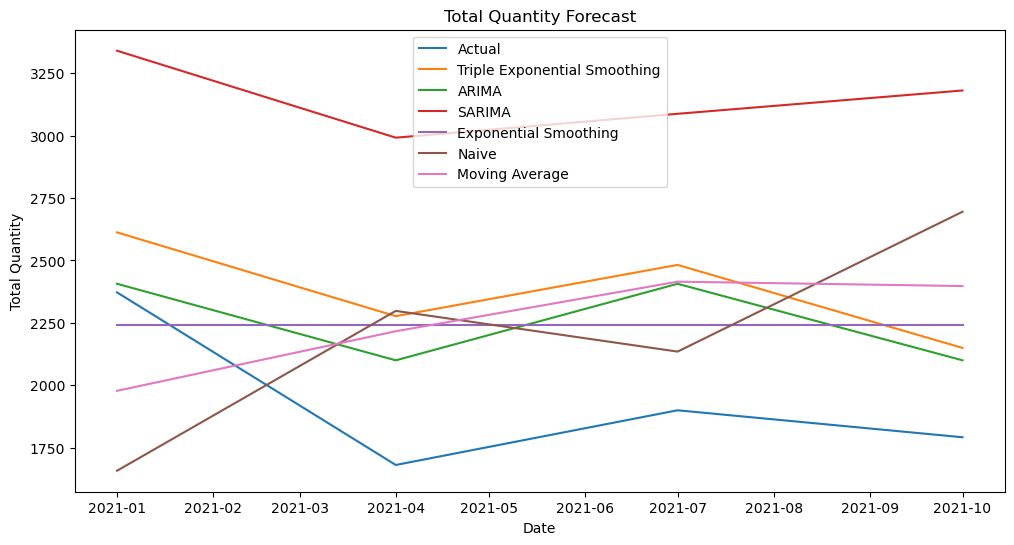

Forecasting for District KÜÇÜKÇEKMECE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69676D+00    |proj g|=  8.66324D-02

At iterate    5    f=  2.63190D+00    |proj g|=  3.61628D-03

At iterate   10    f=  2.63152D+00    |proj g|=  1.74130D-03

At iterate   15    f=  2.63023D+00    |proj g|=  4.95961D-03

At iterate   20    f=  2.62005D+00    |proj g|=  9.45028D-03

At iterate   25    f=  2.61944D+00    |proj g|=  2.43994D-04

At iterate   30    f=  2.61937D+00    |proj g|=  7.69972D-05

At iterate   35    f=  2.61936D+00    |proj g|=  1.04181D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy 

 This problem is unconstrained.


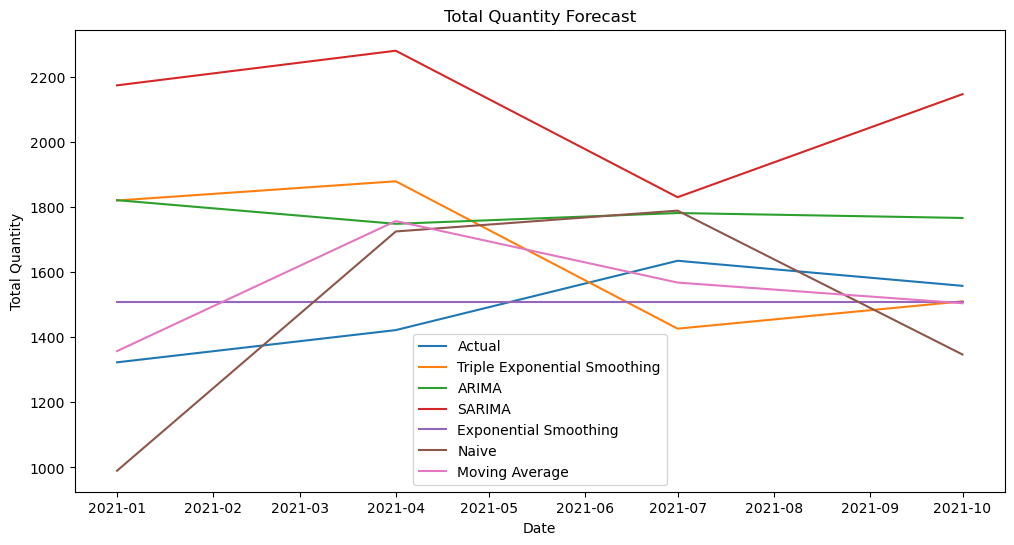

Forecasting for District ÜMRANİYE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77355D+00    |proj g|=  1.68920D-01

At iterate    5    f=  2.70877D+00    |proj g|=  1.86426D-02

At iterate   10    f=  2.70689D+00    |proj g|=  4.83077D-04

At iterate   15    f=  2.70687D+00    |proj g|=  1.14808D-04

At iterate   20    f=  2.70640D+00    |proj g|=  3.32303D-03

At iterate   25    f=  2.70589D+00    |proj g|=  3.51283D-03

At iterate   30    f=  2.70238D+00    |proj g|=  1.09830D-02

At iterate   35    f=  2.69968D+00    |proj g|=  7.25883D-03

At iterate   40    f=  2.69904D+00    |proj g|=  6.46067D-03

At iterate   45    f=  2.69886D+00    |proj g|=  3.17664D-03

At iterate   50    f=  2.69876D+00    |proj g|=  3.62085D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of fun

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


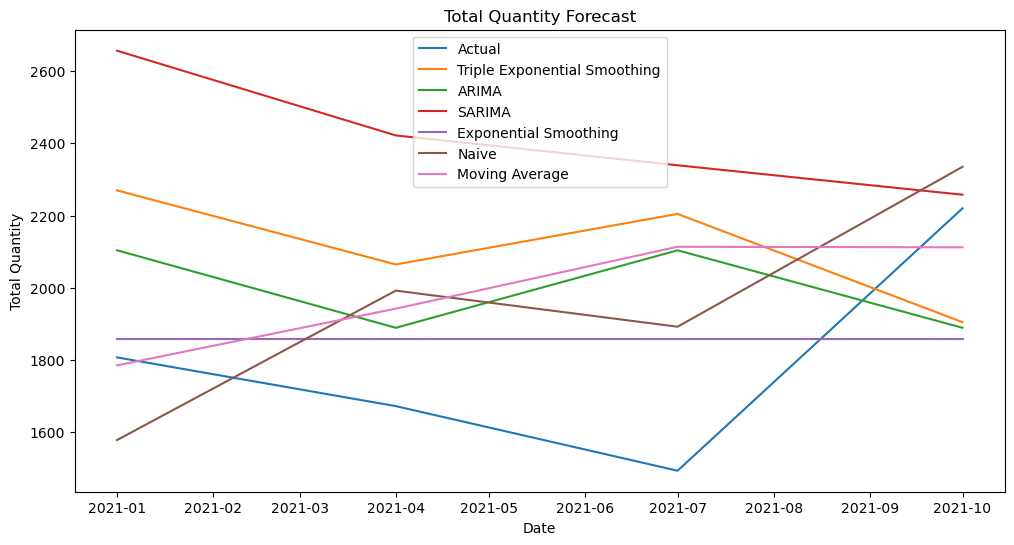

Forecasting for District FATİH
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69425D+00    |proj g|=  2.87069D-01

At iterate    5    f=  2.53652D+00    |proj g|=  1.02169D-02

At iterate   10    f=  2.53098D+00    |proj g|=  3.04260D-03

At iterate   15    f=  2.52804D+00    |proj g|=  9.02224D-03

At iterate   20    f=  2.52655D+00    |proj g|=  1.33799D-03

At iterate   25    f=  2.52341D+00    |proj g|=  1.06179D-03

At iterate   30    f=  2.52266D+00    |proj g|=  1.13718D-03

At iterate   35    f=  2.52244D+00    |proj g|=  7.50837D-04

At iterate   40    f=  2.52240D+00    |proj g|=  3.87436D-05

At iterate   45    f=  2.52240D+00    |proj g|=  5.64788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored durin

 This problem is unconstrained.


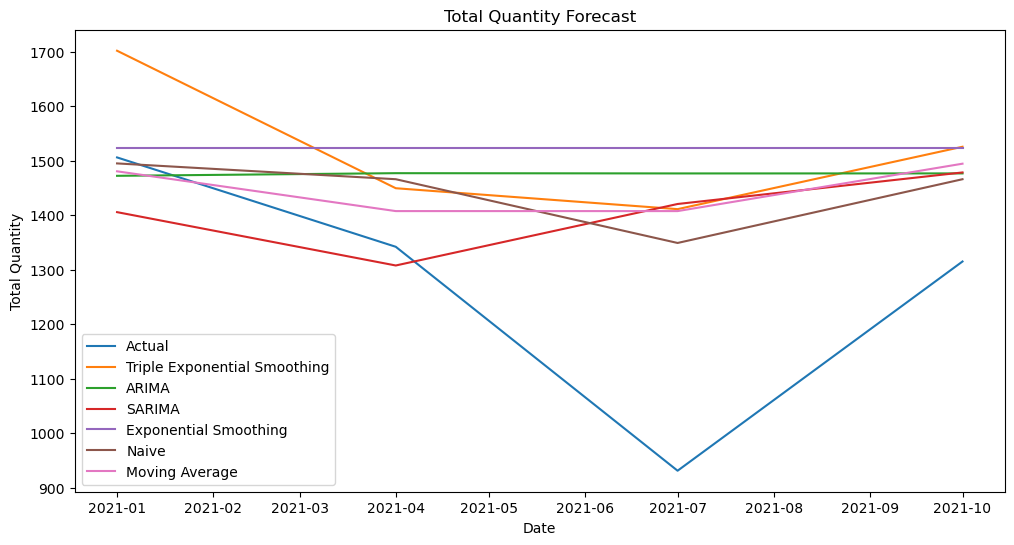

Forecasting for SKU 1018
Forecasting for District PENDİK
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22298D+00    |proj g|=  2.68531D-01

At iterate    5    f=  2.13800D+00    |proj g|=  4.60374D-03

At iterate   10    f=  2.13740D+00    |proj g|=  1.47491D-03

At iterate   15    f=  2.13001D+00    |proj g|=  2.49359D-02

At iterate   20    f=  2.11796D+00    |proj g|=  1.39637D-02

At iterate   25    f=  2.11345D+00    |proj g|=  8.87510D-03

At iterate   30    f=  2.11245D+00    |proj g|=  2.50644D-03

At iterate   35    f=  2.11196D+00    |proj g|=  4.00393D-03

At iterate   40    f=  2.11170D+00    |proj g|=  2.50583D-03

At iterate   45    f=  2.11154D+00    |proj g|=  9.83444D-04

At iterate   50    f=  2.11146D+00    |proj g|=  1.65587D-03

           * * *

Tit   = total number of iterations
Tnf 

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


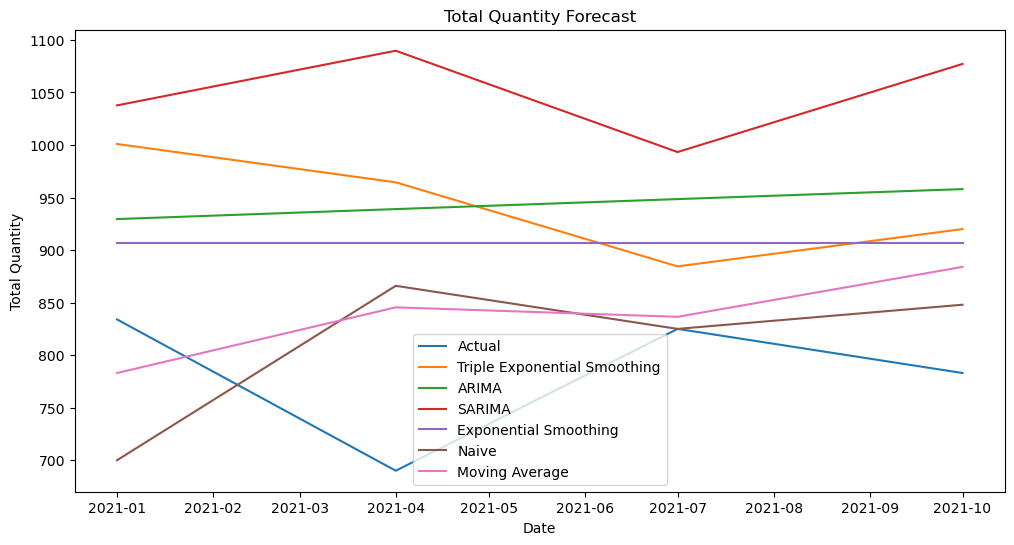

Forecasting for District GAZİOSMANPAŞA
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29483D+00    |proj g|=  2.84780D-01

At iterate    5    f=  2.21256D+00    |proj g|=  2.72270D-03

At iterate   10    f=  2.21234D+00    |proj g|=  1.27408D-03

At iterate   15    f=  2.21002D+00    |proj g|=  1.24507D-02

At iterate   20    f=  2.20425D+00    |proj g|=  2.16218D-03

At iterate   25    f=  2.20301D+00    |proj g|=  2.79936D-03

At iterate   30    f=  2.19969D+00    |proj g|=  1.07544D-02

At iterate   35    f=  2.19793D+00    |proj g|=  1.13913D-02

At iterate   40    f=  2.19739D+00    |proj g|=  2.05675D-03

At iterate   45    f=  2.19735D+00    |proj g|=  2.89402D-03

At iterate   50    f=  2.19730D+00    |proj g|=  8.74037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


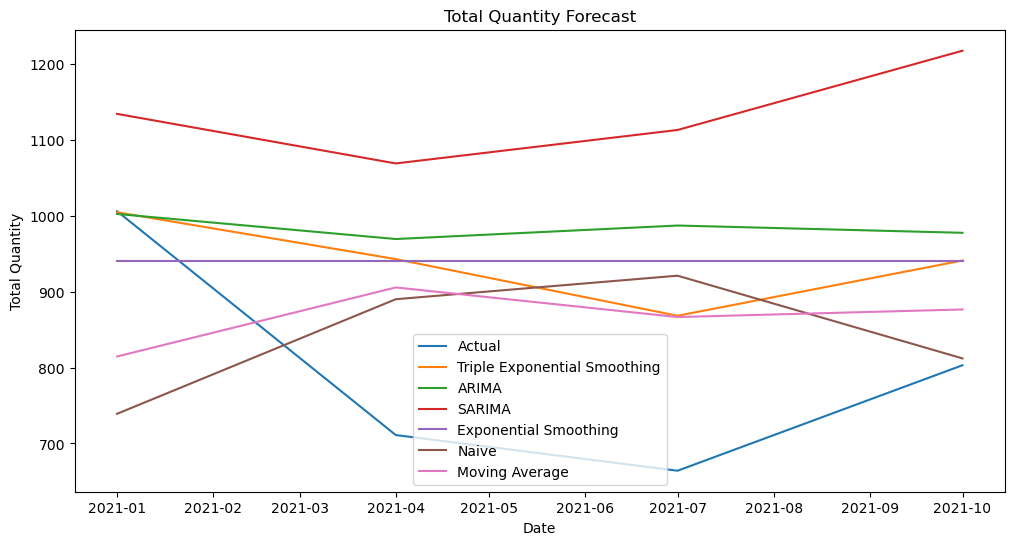

Forecasting for District KÜÇÜKÇEKMECE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66239D+00    |proj g|=  2.40209D-01

At iterate    5    f=  2.55360D+00    |proj g|=  6.61257D-04

At iterate   10    f=  2.55331D+00    |proj g|=  2.31503D-03

At iterate   15    f=  2.51987D+00    |proj g|=  5.53006D-03

At iterate   20    f=  2.51729D+00    |proj g|=  1.78019D-03

At iterate   25    f=  2.51709D+00    |proj g|=  3.03300D-04
  ys=-1.072E-02  -gs= 2.529E-04 BFGS update SKIPPED

At iterate   30    f=  2.50735D+00    |proj g|=  4.19511D-03

At iterate   35    f=  2.45404D+00    |proj g|=  4.46447D-02

At iterate   40    f=  2.43751D+00    |proj g|=  3.10115D-03

At iterate   45    f=  2.43578D+00    |proj g|=  2.03613D-02

At iterate   50    f=  2.43496D+00    |proj g|=  3.00072D-03

           * * *

Tit   

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


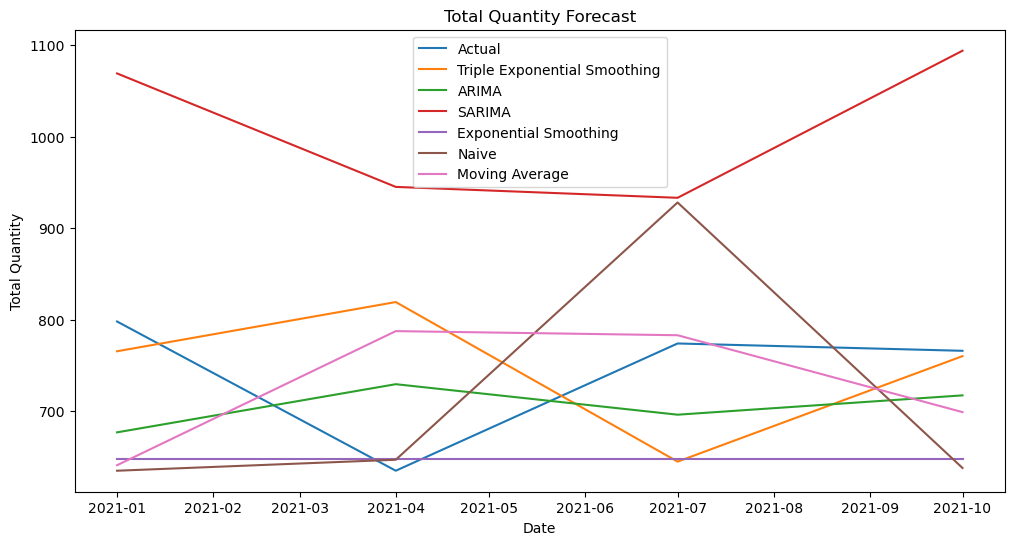

Forecasting for District ÜMRANİYE
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36915D+00    |proj g|=  2.76172D-01

At iterate    5    f=  2.29571D+00    |proj g|=  4.19653D-03

At iterate   10    f=  2.29463D+00    |proj g|=  5.86993D-04

At iterate   15    f=  2.29355D+00    |proj g|=  3.59089D-03

At iterate   20    f=  2.28798D+00    |proj g|=  1.49766D-03

At iterate   25    f=  2.28637D+00    |proj g|=  2.35965D-03

At iterate   30    f=  2.28615D+00    |proj g|=  5.17471D-03

At iterate   35    f=  2.28598D+00    |proj g|=  1.14372D-03

At iterate   40    f=  2.28592D+00    |proj g|=  7.33446D-04

At iterate   45    f=  2.28588D+00    |proj g|=  1.83907D-03

At iterate   50    f=  2.28584D+00    |proj g|=  1.30246D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of fun

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


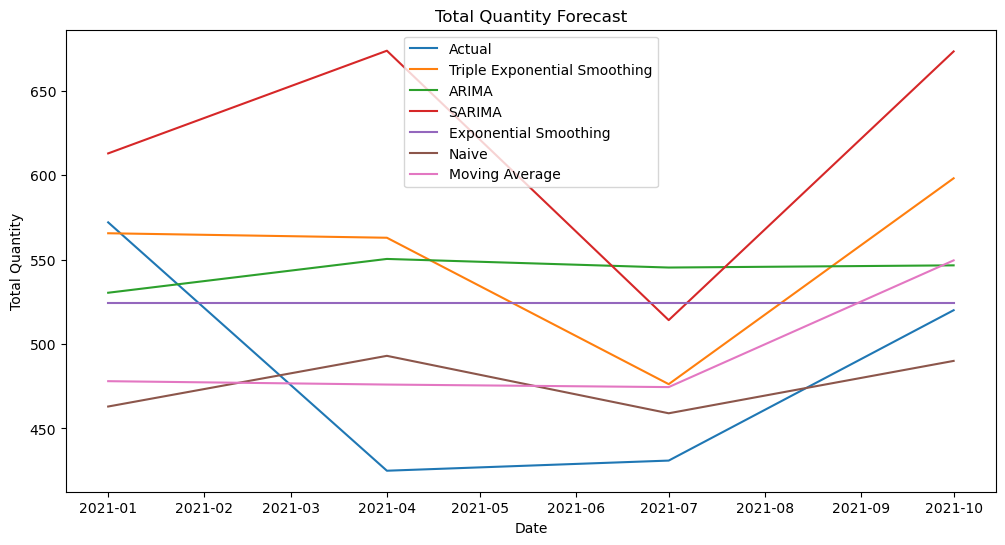

Forecasting for District FATİH
Forecasting for Time Range: Quarter
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39703D+00    |proj g|=  1.07486D-02

At iterate    5    f=  2.34164D+00    |proj g|=  1.29158D-02

At iterate   10    f=  2.34130D+00    |proj g|=  2.82626D-04

At iterate   15    f=  2.34128D+00    |proj g|=  2.33827D-03

At iterate   20    f=  2.34125D+00    |proj g|=  5.51998D-04

At iterate   25    f=  2.34124D+00    |proj g|=  5.79613D-04

At iterate   30    f=  2.34124D+00    |proj g|=  2.62610D-04

At iterate   35    f=  2.34124D+00    |proj g|=  8.16346D-05


 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   40    f=  2.34123D+00    |proj g|=  1.77532D-03

At iterate   45    f=  2.34114D+00    |proj g|=  1.79835D-03

At iterate   50    f=  2.34100D+00    |proj g|=  3.62947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     0     0   3.629D-04   2.341D+00
  F =   2.3409997380629908     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


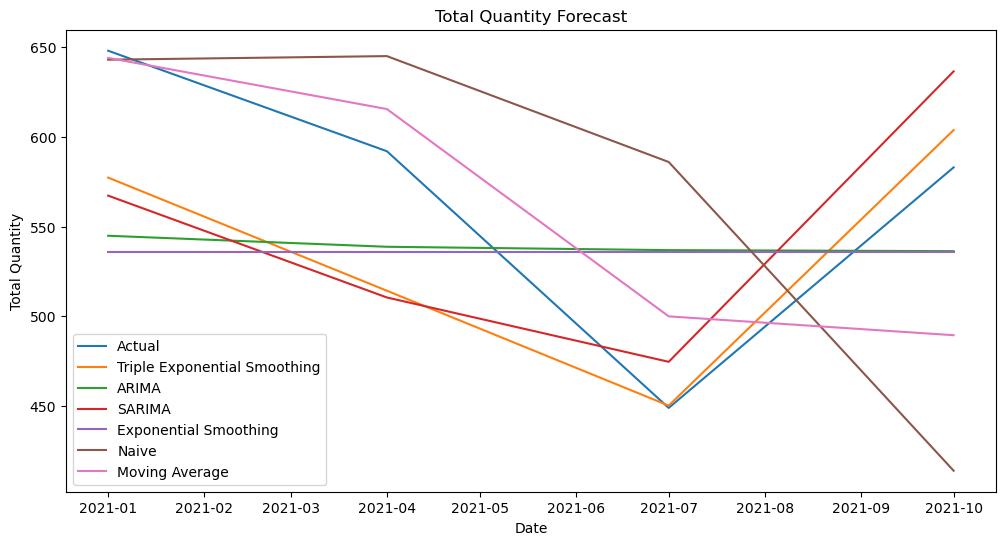

In [37]:
metrics_df_by_district = []

# Iterate over each SKU, District, and Time Range
for sku in all_sku_ids:
    print(f'Forecasting for SKU {sku}')
    
    for district in highest_districts:
        print(f'Forecasting for District {district}')
        
        for time_range in ['Quarter']:
            print(f'Forecasting for Time Range: {time_range}')
            
            forecasts, metrics = forecast_total_quantity_seasonal(df_cleaned, time_range, district, sku)
            
            for model, metric in metrics.items():
                metrics_df_by_district.append({
                    'SKU': sku,
                    'District': district,
                    'Time Range': time_range,
                    'Model': model,
                    'MAPE': metric['MAPE'],
                    'MSE': metric['MSE'],
                    'RMSE': metric['RMSE'],
                    'MAD': metric['MAD']
                })
                
metrics_df_by_district = pd.DataFrame(metrics_df_by_district)

## Forecasting Metrics with District

The following table shows the forecast metrics for each SKU and District based on the different forecasting models and time ranges.

In [38]:
metrics_df_by_district.set_index(['SKU', 'District', 'Time Range', 'Model'], inplace=True)

In [39]:
metrics_df_by_district

MAPE           MSE  \
SKU  District Time Range Model                                                  
568  PENDİK   Quarter    Triple Exponential Smoothing  0.201460  1.806116e+06   
                         ARIMA                         0.251797  2.533126e+06   
                         SARIMA                        0.231516  1.812834e+06   
                         Exponential Smoothing         0.232639  2.201836e+06   
                         Naive                         0.199405  2.189281e+06   
...                                                         ...           ...   
1018 FATİH    Quarter    ARIMA                         0.131207  5.841460e+03   
                         SARIMA                        0.102795  4.169710e+03   
                         Exponential Smoothing         0.135624  6.380559e+03   
                         Naive                         0.173061  1.254100e+04   
                         Moving Average                0.079958  2.977875e+03   

                                                              RMSE  \
SKU  District Time Range Model                                       
568  PENDİK   Quarter    Triple Exponential Smoothing  1343.918327   
                         ARIMA                         1591.579840   
                         SARIMA                        1346.415106   
                         Exponential Smoothing         1483.858520   
                         Naive                         1479.621827   
...                                                            ...   
1018 FATİH    Quarter    ARIMA                           76.429444   
                         SARIMA                          64.573294   
                         Exponential Smoothing           79.878403   
                         Naive                          111.986606   
                         Moving Average                  54.569909   

                                                               MAD  
SKU  District Time Range Model                                      
568  PENDİK   Quarter    Triple Exponential Smoothing  1183.426371  
                         ARIMA                         1470.248312  
                         SARIMA                        1241.921035  
                         Exponential Smoothing         1250.500000  
                         Naive                         1281.250000  
...                                                            ...  
1018 FATİH    Quarter    ARIMA                           72.723172  
                         SARIMA                          60.347990  
                         Exponential Smoothing           75.624975  
                         Naive                           91.000000  
                         Moving Average                  43.000000  

[210 rows x 4 columns]

### Average Metrics for Each SKU

In [40]:
mean_metrics = metrics_df_by_district.groupby(['SKU', 'Model']).mean()
mean_metrics

MAPE           MSE         RMSE  \
SKU  Model                                                               
1018 ARIMA                         0.179653  2.026086e+04   129.955470   
     Exponential Smoothing         0.162184  1.629853e+04   119.664727   
     Moving Average                0.129384  1.183059e+04    99.775007   
     Naive                         0.158443  1.788915e+04   125.953514   
     SARIMA                        0.312141  6.234660e+04   226.727379   
     Triple Exponential Smoothing  0.151358  1.652158e+04   119.213682   
1050 ARIMA                         0.110658  2.659615e+05   499.785223   
     Exponential Smoothing         0.118532  3.045420e+05   536.124630   
     Moving Average                0.182370  7.586933e+05   845.460023   
     Naive                         0.267935  1.378870e+06  1144.846872   
     SARIMA                        0.619515  8.008912e+06  2524.470918   
     Triple Exponential Smoothing  0.155403  4.049073e+05   632.175343   
319  ARIMA                         0.164186  2.886156e+05   532.880685   
     Exponential Smoothing         0.153518  2.657505e+05   512.129463   
     Moving Average                0.149343  3.132950e+05   541.922699   
     Naive                         0.182470  4.978165e+05   686.877067   
     SARIMA                        0.172799  2.659855e+05   476.428133   
     Triple Exponential Smoothing  0.113970  1.708883e+05   405.629663   
509  ARIMA                         0.112307  3.120568e+04   173.937921   
     Exponential Smoothing         0.109922  2.941597e+04   168.658705   
     Moving Average                0.169548  6.227516e+04   244.455390   
     Naive                         0.193907  9.107340e+04   296.263081   
     SARIMA                        0.180135  9.002817e+04   282.841710   
     Triple Exponential Smoothing  0.136925  3.614554e+04   183.838865   
568  ARIMA                         0.204718  3.282502e+06  1787.071144   
     Exponential Smoothing         0.211419  3.719571e+06  1885.310079   
     Moving Average                0.212815  3.408138e+06  1815.180782   
     Naive                         0.216085  3.946218e+06  1934.878414   
     SARIMA                        0.332668  7.396130e+06  2446.574942   
     Triple Exponential Smoothing  0.205360  2.950347e+06  1687.352592   
578  ARIMA                         0.225459  2.852222e+06  1378.820420   
     Exponential Smoothing         0.228741  3.150568e+06  1433.464331   
     Moving Average                0.223207  2.847653e+06  1357.272947   
     Naive                         0.257062  2.908875e+06  1456.560251   
     SARIMA                        0.523565  9.430873e+06  2678.635901   
     Triple Exponential Smoothing  0.225070  2.625143e+06  1347.273360   
615  ARIMA                         0.215885  1.478001e+05   376.975399   
     Exponential Smoothing         0.186538  1.249660e+05   328.360787   
     Moving Average                0.195550  1.628698e+05   373.601924   
     Naive                         0.238897  2.312336e+05   431.379692   
     SARIMA                        0.420978  6.332432e+05   734.437529   
     Triple Exponential Smoothing  0.230191  1.632828e+05   396.818879   

                                           MAD  
SKU  Model                                      
1018 ARIMA                          117.176287  
     Exponential Smoothing          107.921624  
     Moving Average                  87.825000  
     Naive                          107.150000  
     SARIMA                         212.531269  
     Triple Exponential Smoothing   100.167382  
1050 ARIMA                          416.082832  
     Exponential Smoothing          451.770939  
     Moving Average                 655.275000  
     Naive                          994.450000  
     SARIMA                        2366.503066  
     Triple Exponential Smoothing   560.833992  
319  ARIMA                          426.041605  
     Exponential Smoothing          403.539997 

In [41]:
# make more readable for numbers, round to 3 digits
mean_metrics.round(3)

MAPE          MSE      RMSE       MAD
SKU  Model                                                               
1018 ARIMA                         0.180    20260.857   129.955   117.176
     Exponential Smoothing         0.162    16298.534   119.665   107.922
     Moving Average                0.129    11830.588    99.775    87.825
     Naive                         0.158    17889.150   125.954   107.150
     SARIMA                        0.312    62346.600   226.727   212.531
     Triple Exponential Smoothing  0.151    16521.584   119.214   100.167
1050 ARIMA                         0.111   265961.491   499.785   416.083
     Exponential Smoothing         0.119   304542.009   536.125   451.771
     Moving Average                0.182   758693.288   845.460   655.275
     Naive                         0.268  1378869.650  1144.847   994.450
     SARIMA                        0.620  8008912.407  2524.471  2366.503
     Triple Exponential Smoothing  0.155   404907.272   632.175   560.834
319  ARIMA                         0.164   288615.575   532.881   426.042
     Exponential Smoothing         0.154   265750.537   512.129   403.540
     Moving Average                0.149   313295.038   541.923   426.175
     Naive                         0.182   497816.450   686.877   525.150
     SARIMA                        0.173   265985.548   476.428   415.440
     Triple Exponential Smoothing  0.114   170888.293   405.630   307.445
509  ARIMA                         0.112    31205.677   173.938   152.093
     Exponential Smoothing         0.110    29415.967   168.659   146.836
     Moving Average                0.170    62275.162   244.455   226.425
     Naive                         0.194    91073.400   296.263   251.100
     SARIMA                        0.180    90028.170   282.842   254.466
     Triple Exponential Smoothing  0.137    36145.538   183.839   173.622
568  ARIMA                         0.205  3282501.622  1787.071  1411.191
     Exponential Smoothing         0.211  3719571.418  1885.310  1475.304
     Moving Average                0.213  3408138.238  1815.181  1488.525
     Naive                         0.216  3946217.850  1934.878  1505.850
     SARIMA                        0.333  7396130.497  2446.575  2221.716
     Triple Exponential Smoothing  0.205  2950347.210  1687.353  1449.326
578  ARIMA                         0.225  2852221.898  1378.820  1083.654
     Exponential Smoothing         0.229  3150568.008  1433.464  1085.449
     Moving Average                0.223  2847653.175  1357.273  1019.050
     Naive                         0.257  2908875.400  1456.560  1139.100
     SARIMA                        0.524  9430872.800  2678.636  2332.284
     Triple Exponential Smoothing  0.225  2625143.114  1347.273  1054.148
615  ARIMA                         0.216   147800.127   376.975   316.664
     Exponential Smoothing         0.187   124966.021   328.361   273.712
     Moving Average                0.196   162869.838   373.602   284.925
     Naive                         0.239   231233.650   431.380   359.350
     SARIMA                        0.421   633243.217   734.438   679.407
     Triple Exponential Smoothing  0.230   163282.833   396.819   344.211